# Flow Field Reconstruction with 8 Edge Sensors

This notebook implements a physics-informed machine learning approach to reconstruct flow fields using data from 8 edge sensors. The implementation uses:
- Variational Autoencoder (VAE) for dimensionality reduction and flow field reconstruction
- Fourier feature embeddings for coordinate information
- FLRNet architecture to predict flow fields from sparse sensor measurements

## 1. Import Required Libraries

We'll import the necessary libraries for data manipulation, visualization, and deep learning.

In [1]:
# Standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import time
import datetime
import importlib
import sys

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras

# Suppress TensorFlow warnings and info messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Force reload of modules
if 'models_improved' in sys.modules:
    importlib.reload(sys.modules['models_improved'])
if 'config_manager' in sys.modules:
    importlib.reload(sys.modules['config_manager'])
if 'data.flow_field_dataset' in sys.modules:
    importlib.reload(sys.modules['data.flow_field_dataset'])

# Now import everything
import models_improved
import config_manager
from data.flow_field_dataset import FlowFieldDatasetCreator

print(f"TensorFlow version: {tf.__version__}")

# Configure GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(f"Found {len(gpus)} GPU(s): {gpus}")
    for gpu in gpus:
        print(f"Using GPU: {gpu}")
        # Enable memory growth to avoid allocation issues
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPUs found, using CPU")

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

Flow Field Dataset Creation Package v1.0.0 loaded successfully!

Quick Start:
  from dataset_creation import FlowFieldDatasetCreator
  creator = FlowFieldDatasetCreator()
  creator.create_all_datasets()

For more info: print_package_info()
TensorFlow version: 2.8.0
Found 1 GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 2. Configuration Setup

Let's set up the configuration for our model training:

In [2]:
# Load configuration using ConfigManager
config_name = "random_32_no_fourier_no_percep" 
config_mgr = config_manager.ConfigManager()
hierarchical_config = config_mgr.load_config(config_name)

# Print configuration summary
print(config_mgr.create_config_summary(hierarchical_config))

# Flatten the config for training (with lowercase keys for Python style)
flattened_config = config_manager.flatten_config_for_training(hierarchical_config)

# Convert to lowercase keys for consistent Python style
config = {}
for key, value in flattened_config.items():
    config[key.lower()] = value

print("\n🔧 Final Configuration (lowercase keys):")
print(f"   Model name: {config['model_name']}")
print(f"   Use Fourier: {config['use_fourier']}")
print(f"   Use perceptual loss: {config['use_perceptual_loss']}")
print(f"   Input shape: {config['input_shape']}")
print(f"   Number of sensors: {config['n_sensors']}")
print(f"   Latent dims: {config['latent_dims']}")
print(f"   Base features: {config['n_base_features']}")
print(f"   Batch size: {config['batch_size']}")
print(f"   VAE epochs: {config['vae_epochs']}")
print(f"   FLRNet epochs: {config['flr_epochs']}")
print(f"   VAE learning rate: {config['vae_learning_rate']}")
print(f"   FLRNet learning rate: {config['flr_learning_rate']}")
print(f"   Dataset path: {config['dataset_path']}")
print(f"   Checkpoint dir: {config['checkpoint_dir']}")
print(f"   Logs dir: {config['logs_dir']}")

# Verify essential config keys exist
required_keys = ['model_name', 'use_fourier', 'use_perceptual_loss', 'input_shape', 
                 'n_sensors', 'latent_dims', 'n_base_features', 'batch_size', 
                 'vae_epochs', 'flr_epochs', 'vae_learning_rate', 'flr_learning_rate',
                 'dataset_path', 'checkpoint_dir', 'logs_dir']
missing_keys = [key for key in required_keys if key not in config]
if missing_keys:
    print(f"⚠️  Missing required config keys: {missing_keys}")
else:
    print("✅ All required configuration keys are present")


📋 Configuration Summary
🏗️  Model Architecture:
   - Fourier Enhancement: False
   - Perceptual Loss: False
   - Input Shape: [128, 256, 1]
   - Latent Dimensions: 8
   - Base Features: 64

📡 Sensor Configuration:
   - Layout: random
   - Number of Sensors: 32
   - Dataset: data/datasets\dataset_random_32.npz

🚀 Training Parameters:
   - VAE Epochs: 250
   - FLRNet Epochs: 150
   - VAE Learning Rate: 0.0001
   - FLRNet Learning Rate: 0.0001
   - Batch Size: 8
   - Test Split: 0.2

💾 Output Configuration:
   - Model Name: fourierFalse_percepFalse_random_32
   - Checkpoints: ./checkpoints\fourierFalse_percepFalse_random_32
   - Logs: ./logs\fourierFalse_percepFalse_random_32
   - Save Best Model: True
   - Save Last Model: True


🔧 Final Configuration (lowercase keys):
   Model name: fourierFalse_percepFalse_random_32
   Use Fourier: False
   Use perceptual loss: False
   Input shape: (128, 256, 1)
   Number of sensors: 32
   Latent dims: 8
   Base features: 64
   Batch size: 8
   VAE e

## 3. Load and Prepare Dataset

We'll load the flow field dataset and the sensor layout for 8 edge sensors:

In [3]:
# Load and prepare dataset created from data_creation_and_viz.ipynb
print(f"📂 Loading dataset from: {config['dataset_path']}")

# Parse the dataset filename to get layout and n_sensors
dataset_filename = Path(config['dataset_path']).name
# Expected format: dataset_edge_8.npz
parts = dataset_filename.split('_')
layout_type = parts[1]  # 'edge'
n_sensors = int(parts[2].split('.')[0])  # 8

print(f"📊 Dataset parameters:")
print(f"   Layout type: {layout_type}")
print(f"   Number of sensors: {n_sensors}")

# Load the dataset directly from the NPZ file
print(f"📁 Loading dataset file: {config['dataset_path']}")
data = np.load(config['dataset_path'])

# Check what keys are available in the dataset
print(f"📋 Available keys in dataset: {list(data.keys())}")

# Create dataset dictionary
dataset = {key: data[key] for key in data.keys()}

# Print dataset information
print(f"📊 Dataset loaded successfully:")
for key, value in dataset.items():
    if isinstance(value, np.ndarray):
        print(f"   {key}: {value.shape} ({value.dtype})")
    else:
        print(f"   {key}: {value}")

# Extract sensor positions
sensor_positions = dataset['sensor_positions']
print(f"📍 Sensor positions shape: {sensor_positions.shape}")

# Create dataset creator instance for TensorFlow dataset creation
creator = FlowFieldDatasetCreator(
    output_path="./data/",
    domain_shape=config['input_shape'][:2],  # (height, width)
    use_synthetic_data=False  # Don't create synthetic data, just use for TF dataset creation
)

# Create TensorFlow datasets using the creator's method
train_dataset, test_dataset = creator.create_tensorflow_dataset(
    dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    test_split=config['test_split']
)

print(f"\n📊 TensorFlow datasets created:")
print(f"   Train dataset: {train_dataset}")
print(f"   Test dataset: {test_dataset}")

# Function to add coordinate grids to field data for Fourier-aware VAE training
def add_coordinate_grid(batch):
    """Add coordinate grid to field data for Fourier VAE training"""
    field_data = batch['field_data']
    
    # Get dimensions
    batch_size = tf.shape(field_data)[0]
    height = tf.shape(field_data)[1]
    width = tf.shape(field_data)[2]
    
    # Create normalized coordinate grids [0, 1] - match field dimensions
    x_coords = tf.linspace(0.0, 1.0, width)   # Width corresponds to x
    y_coords = tf.linspace(0.0, 1.0, height)  # Height corresponds to y
    
    # Create meshgrid to match image indexing: [height, width, 2]
    y_grid, x_grid = tf.meshgrid(y_coords, x_coords, indexing='ij')
    
    # Stack to create coordinate grid (height, width, 2)
    coord_grid = tf.stack([x_grid, y_grid], axis=-1)
    
    # Expand to batch size (batch_size, height, width, 2)
    coord_batch = tf.tile(tf.expand_dims(coord_grid, 0), [batch_size, 1, 1, 1])
    
    # Update batch to include coordinates
    return {
        'field_data': field_data,
        'sensor_data': batch['sensor_data'],
        'coordinates': coord_batch
    }

# Add coordinate grids to datasets
coord_train_dataset = train_dataset.map(add_coordinate_grid)
coord_test_dataset = test_dataset.map(add_coordinate_grid)

print(f"\n📊 Coordinate-aware datasets created:")
print(f"   Train dataset with coordinates: {coord_train_dataset}")
print(f"   Test dataset with coordinates: {coord_test_dataset}")

# Create specialized datasets for VAE and FLRNet training
# VAE trains on field reconstruction WITH coordinates for Fourier features
if config['use_fourier']:
    print("\n🌊 Creating Fourier-aware VAE datasets...")
    # For Fourier VAE: input = (field, coordinates), output = field
    vae_train_dataset = coord_train_dataset.map(
        lambda batch: ((batch['field_data'], batch['coordinates']), batch['field_data'])
    )
    vae_test_dataset = coord_test_dataset.map(
        lambda batch: ((batch['field_data'], batch['coordinates']), batch['field_data'])
    )
    print("✅ Fourier-aware VAE datasets created")
else:
    print("\n🔄 Creating standard VAE datasets...")
    # Standard VAE: input = field, output = field
    vae_train_dataset = coord_train_dataset.map(
        lambda batch: (batch['field_data'], batch['field_data'])
    )
    vae_test_dataset = coord_test_dataset.map(
        lambda batch: (batch['field_data'], batch['field_data'])
    )
    print("✅ Standard VAE datasets created")

# FLRNet trains on sensor-to-field reconstruction 
if config['use_fourier']:
    print("\n🌊 Creating Fourier-aware FLRNet datasets...")
    # For Fourier FLRNet: input = (sensor, field, coordinates), output = field
    flrnet_train_dataset = coord_train_dataset.map(
        lambda batch: (batch['sensor_data'], batch['field_data'], batch['coordinates'])
    )
    flrnet_test_dataset = coord_test_dataset.map(
        lambda batch: (batch['sensor_data'], batch['field_data'], batch['coordinates'])
    )
    print("✅ Fourier-aware FLRNet datasets created")
else:
    print("\n🔄 Creating standard FLRNet datasets...")
    # Standard FLRNet: input = (sensor, field), output = field
    flrnet_train_dataset = coord_train_dataset.map(
        lambda batch: (batch['sensor_data'], batch['field_data'])
    )
    flrnet_test_dataset = coord_test_dataset.map(
        lambda batch: (batch['sensor_data'], batch['field_data'])
    )
    print("✅ Standard FLRNet datasets created")

print(f"\n📊 Specialized datasets:")
print(f"   VAE train dataset: {vae_train_dataset}")
print(f"   VAE test dataset: {vae_test_dataset}")
print(f"   FLRNet train dataset: {flrnet_train_dataset}")
print(f"   FLRNet test dataset: {flrnet_test_dataset}")

# Get a sample to verify data shapes
print(f"\n📊 Data shape verification:")
for batch in coord_train_dataset.take(1):
    print(f"   Sensor data shape: {batch['sensor_data'].shape}")
    print(f"   Field data shape: {batch['field_data'].shape}")
    print(f"   Coordinates shape: {batch['coordinates'].shape}")
    break

# Verify VAE dataset structure
print(f"\n📊 VAE dataset structure verification:")
for vae_batch in vae_train_dataset.take(1):
    if config['use_fourier']:
        inputs, targets = vae_batch
        if isinstance(inputs, tuple):
            field_input, coord_input = inputs
            print(f"   VAE field input shape: {field_input.shape}")
            print(f"   VAE coordinate input shape: {coord_input.shape}")
            print(f"   VAE target shape: {targets.shape}")
        else:
            print(f"   Unexpected VAE input format: {type(inputs)}")
    else:
        inputs, targets = vae_batch
        print(f"   VAE input shape: {inputs.shape}")
        print(f"   VAE target shape: {targets.shape}")
    break

📂 Loading dataset from: data/datasets\dataset_random_32.npz
📊 Dataset parameters:
   Layout type: random
   Number of sensors: 32
📁 Loading dataset file: data/datasets\dataset_random_32.npz
📋 Available keys in dataset: ['sensor_data', 'field_data', 'sensor_positions', 'reynolds_numbers', 'layout_type', 'n_sensors']
📊 Dataset loaded successfully:
   sensor_data: (28, 32, 39) (float64)
   field_data: (28, 128, 256, 39) (float64)
   sensor_positions: (32, 2) (float64)
   reynolds_numbers: (28,) (int32)
   layout_type: () (<U6)
   n_sensors: () (int32)
📍 Sensor positions shape: (32, 2)
📊 Dataset Creator initialized:
   Domain shape: (128, 256)
   Caching: ✅ ENABLED
   Cache directory: data\cache
Dataset reshaped:
  Original sensor data: (28, 32, 39)
  Reshaped sensor data: (1092, 32)
  Original field data: (28, 128, 256, 39)
  Reshaped field data: (1092, 128, 256, 1)
  Total samples: 1092
TensorFlow datasets created:
  Train samples: 873
  Test samples: 219

📊 TensorFlow datasets created:


## 5. Train VAE and FLRNet Models

Now we'll train our models using the FLRTrainer:
1. First, the Variational Autoencoder (VAE) to learn a compressed representation of flow fields
2. Then, the FLRNet to reconstruct flow fields from sparse sensor measurements

In [4]:
# Load test dataset similar to train dataset - OPTIMIZED VERSION
print(f"📂 Loading test dataset...")

# Create test dataset path by adding 'test_' prefix to the filename
test_dataset_path = str(Path(config['dataset_path']).parent / f"test_{Path(config['dataset_path']).name}")
print(f"📁 Test dataset path: {test_dataset_path}")

# Check if test dataset exists
if not Path(test_dataset_path).exists():
    print(f"❌ Test dataset not found: {test_dataset_path}")
    print("⚠️  Skipping test dataset creation - using training data split instead")
    
    # Use existing training datasets with 'test_' prefix for naming
    test_coord_train_dataset = coord_train_dataset
    test_coord_test_dataset = coord_test_dataset
    test_sensor_positions = sensor_positions
    
else:
    # Parse the test dataset filename to get layout and n_sensors
    test_dataset_filename = Path(test_dataset_path).name
    test_parts = test_dataset_filename.split('_')
    test_layout_type = test_parts[2] if len(test_parts) > 2 else "unknown"
    test_n_sensors = int(test_parts[3].split('.')[0]) if len(test_parts) > 3 else config['n_sensors']

    print(f"📊 Test dataset parameters:")
    print(f"   Layout type: {test_layout_type}")
    print(f"   Number of sensors: {test_n_sensors}")

    # Load the test dataset directly from the NPZ file
    print(f"📁 Loading test dataset file...")
    test_data = np.load(test_dataset_path)

    # Create test dataset dictionary (only essential keys)
    essential_keys = ['field_data', 'sensor_data', 'sensor_positions']
    test_dataset = {}
    for key in essential_keys:
        if key in test_data:
            test_dataset[key] = test_data[key]
        else:
            print(f"⚠️  Missing key '{key}' in test dataset")

    # Print basic test dataset information
    print(f"📊 Test dataset loaded:")
    for key, value in test_dataset.items():
        if isinstance(value, np.ndarray):
            print(f"   {key}: {value.shape}")

    # Extract test sensor positions
    test_sensor_positions = test_dataset.get('sensor_positions', sensor_positions)

    # Create TensorFlow test datasets - OPTIMIZED: smaller batch size and limited data
    print(f"📊 Creating TensorFlow test datasets...")
    
    # Limit test dataset size for faster processing
    max_test_samples = min(1000, len(test_dataset['field_data']))  # Limit to 1000 samples
    
    # Create smaller test dataset dictionary
    limited_test_dataset = {}
    for key, value in test_dataset.items():
        if isinstance(value, np.ndarray) and len(value) > max_test_samples:
            limited_test_dataset[key] = value[:max_test_samples]
        else:
            limited_test_dataset[key] = value
    
    print(f"   Limited to {max_test_samples} samples for performance")
    
    # Use smaller batch size for test data
    test_batch_size = min(16, config['batch_size'])  # Smaller batch size
    
    test_train_dataset, test_test_dataset = creator.create_tensorflow_dataset(
        limited_test_dataset,
        batch_size=test_batch_size,
        shuffle=False,  # Don't shuffle test data
        test_split=1.0
    )

    # Add coordinate grids to test datasets
    test_coord_train_dataset = test_train_dataset.map(add_coordinate_grid)
    test_coord_test_dataset = test_test_dataset.map(add_coordinate_grid)

print(f"\n📊 Test coordinate-aware datasets ready:")
print(f"   Test train dataset: {test_coord_train_dataset}")
print(f"   Test test dataset: {test_coord_test_dataset}")

# Create specialized test datasets - OPTIMIZED: only create what's needed
print(f"\n🔧 Creating specialized test datasets...")

# Determine which datasets to create based on config
create_fourier = config.get('use_fourier', False)
print(f"   Fourier mode: {'✅ ENABLED' if create_fourier else '❌ DISABLED'}")

# VAE test datasets
if create_fourier:
    print("🌊 Creating Fourier-aware test VAE datasets...")
    test_vae_train_dataset = test_coord_train_dataset.map(
        lambda batch: ((batch['field_data'], batch['coordinates']), batch['field_data'])
    ).prefetch(tf.data.AUTOTUNE)  # Add prefetching
    test_vae_test_dataset = test_coord_test_dataset.map(
        lambda batch: ((batch['field_data'], batch['coordinates']), batch['field_data'])
    ).prefetch(tf.data.AUTOTUNE)
else:
    print("🔄 Creating standard test VAE datasets...")
    test_vae_train_dataset = test_coord_train_dataset.map(
        lambda batch: (batch['field_data'], batch['field_data'])
    ).prefetch(tf.data.AUTOTUNE)
    test_vae_test_dataset = test_coord_test_dataset.map(
        lambda batch: (batch['field_data'], batch['field_data'])
    ).prefetch(tf.data.AUTOTUNE)

# FLRNet test datasets
if create_fourier:
    print("🌊 Creating Fourier-aware test FLRNet datasets...")
    test_flrnet_train_dataset = test_coord_train_dataset.map(
        lambda batch: (batch['sensor_data'], batch['field_data'], batch['coordinates'])
    ).prefetch(tf.data.AUTOTUNE)
    test_flrnet_test_dataset = test_coord_test_dataset.map(
        lambda batch: (batch['sensor_data'], batch['field_data'], batch['coordinates'])
    ).prefetch(tf.data.AUTOTUNE)
else:
    print("🔄 Creating standard test FLRNet datasets...")
    test_flrnet_train_dataset = test_coord_train_dataset.map(
        lambda batch: (batch['sensor_data'], batch['field_data'])
    ).prefetch(tf.data.AUTOTUNE)
    test_flrnet_test_dataset = test_coord_test_dataset.map(
        lambda batch: (batch['sensor_data'], batch['field_data'])
    ).prefetch(tf.data.AUTOTUNE)

print(f"\n✅ Test specialized datasets created:")
print(f"   Test VAE train dataset: Ready")
print(f"   Test VAE test dataset: Ready") 
print(f"   Test FLRNet train dataset: Ready")
print(f"   Test FLRNet test dataset: Ready")

# Quick verification with single batch - OPTIMIZED: minimal verification
print(f"\n🔍 Quick data verification:")
try:
    # Get one small batch for verification
    sample_batch = next(iter(test_coord_train_dataset.take(1)))
    print(f"   ✅ Sensor data shape: {sample_batch['sensor_data'].shape}")
    print(f"   ✅ Field data shape: {sample_batch['field_data'].shape}")
    print(f"   ✅ Coordinates shape: {sample_batch['coordinates'].shape}")
    
    # Quick VAE dataset verification
    vae_sample = next(iter(test_vae_train_dataset.take(1)))
    if create_fourier:
        inputs, targets = vae_sample
        if isinstance(inputs, tuple):
            print(f"   ✅ VAE Fourier inputs: field {inputs[0].shape}, coord {inputs[1].shape}")
        else:
            print(f"   ⚠️  VAE input format: {type(inputs)}")
    else:
        inputs, targets = vae_sample
        print(f"   ✅ VAE standard input: {inputs.shape}")
    
    print(f"   ✅ All test datasets verified successfully!")
    
except Exception as e:
    print(f"   ⚠️  Verification warning: {str(e)[:100]}...")
    print(f"   Datasets created but verification failed - may still work")

print(f"\n🎉 Test dataset loading completed!")
print(f"   Performance optimizations applied:")
print(f"   - Limited to {max_test_samples if 'max_test_samples' in locals() else 'existing'} samples")
print(f"   - Smaller batch size: {test_batch_size if 'test_batch_size' in locals() else config['batch_size']}")
print(f"   - Added prefetching for better performance")
print(f"   - Minimal verification for faster execution")

📂 Loading test dataset...
📁 Test dataset path: data\datasets\test_dataset_random_32.npz
📊 Test dataset parameters:
   Layout type: random
   Number of sensors: 32
📁 Loading test dataset file...
📊 Test dataset loaded:
   field_data: (8, 128, 256, 39)
   sensor_data: (8, 32, 39)
   sensor_positions: (32, 2)
📊 Creating TensorFlow test datasets...
   Limited to 8 samples for performance
Dataset reshaped:
  Original sensor data: (8, 32, 39)
  Reshaped sensor data: (312, 32)
  Original field data: (8, 128, 256, 39)
  Reshaped field data: (312, 128, 256, 1)
  Total samples: 312
TensorFlow datasets created:
  Train samples: 0
  Test samples: 312

📊 Test coordinate-aware datasets ready:
   Test train dataset: <MapDataset element_spec={'field_data': TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None), 'sensor_data': TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), 'coordinates': TensorSpec(shape=(None, 128, 256, 2), dtype=tf.float32, name=None)}>
   Test test dataset: <M

## Load Trained Models from Checkpoint

Now let's load the trained models from saved checkpoints using the FLRTrainer's built-in methods. The trainer provides several loading options:

- **`load_vae_from_checkpoint()`**: Load only the VAE model
- **`load_flrnet_from_checkpoint()`**: Load only the FLRNet model  
- **`load_models_from_checkpoint()`**: Load both models at once

### Features:
- **Automatic checkpoint detection**: Finds the best available checkpoint (best → last → final_weights)
- **Robust path handling**: Uses correct TensorFlow checkpoint format (no file extensions)
- **Error handling**: Graceful fallback and clear error messages
- **Architecture consistency**: Ensures loaded model matches trainer configuration
- **Smart dependencies**: FLRNet loading automatically handles VAE dependencies

In [5]:
import os
import shutil
import time
import glob

# Clear TensorFlow session to fix any shape mismatches
print("🔄 Clearing TensorFlow session...")
tf.keras.backend.clear_session()

# Initialize FLRTrainer from models_improved.py
print("🚀 Initializing FLRTrainer...")

# Create the FLRTrainer instance
trainer = models_improved.FLRTrainer(
    input_shape=config['input_shape'],
    use_fourier=config['use_fourier'],
    checkpoint_dir=config['checkpoint_dir'],
    logs_dir=config['logs_dir'],
    model_name=config['model_name'],
    save_best_model=config['save_best_model'],
    save_last_model=config['save_last_model'],
    gradient_clip_norm=config['gradient_clip_norm']
)

print(f"✅ FLRTrainer initialized:")
print(f"   Input shape: {config['input_shape']}")
print(f"   Use Fourier: {config['use_fourier']}")
print(f"   Model name: {config['model_name']}")
print(f"   Gradient clipping: {config['gradient_clip_norm']}")
print(f"   Checkpoints: {config['checkpoint_dir']}")
print(f"   Logs: {config['logs_dir']}")
print(f"   Save best model: {config['save_best_model']}")
print(f"   Save last model: {config['save_last_model']}")

# Set training flags
train_vae_model = False  # Set to False if you want to skip VAE training
train_flrnet_model = False  # Set to True to test FLRNet with proper Fourier features

print(f"\n🔧 Training configuration:")
print(f"   Train VAE: {train_vae_model}")
print(f"   Train FLRNet: {train_flrnet_model}")

🔄 Clearing TensorFlow session...
🚀 Initializing FLRTrainer...
✅ FLRTrainer initialized:
   Input shape: (128, 256, 1)
   Use Fourier: False
   Model name: fourierFalse_percepFalse_random_32
   Gradient clipping: 2.0
   Checkpoints: ./checkpoints\fourierFalse_percepFalse_random_32
   Logs: ./logs\fourierFalse_percepFalse_random_32
   Save best model: True
   Save last model: True

🔧 Training configuration:
   Train VAE: False
   Train FLRNet: False


In [6]:
import os
import glob
from pathlib import Path
import tensorflow as tf

# Load the VAE model using the trainer's built-in method
print("🚀 Loading trained VAE model from checkpoint using FLRTrainer...")
print("=" * 60)

# Fix checkpoint path - use the directory, not the specific file
checkpoint_directory = Path(config['checkpoint_dir'])
print(f"📂 Using checkpoint directory: {checkpoint_directory}")

# List available checkpoints for debugging
if checkpoint_directory.exists():
    print(f"📋 Available checkpoint files:")
    for file in sorted(checkpoint_directory.iterdir()):
        print(f"   - {file.name}")
else:
    print(f"❌ Checkpoint directory not found: {checkpoint_directory}")

# Use the trainer's built-in checkpoint loading method
vae_model = trainer.load_vae_from_checkpoint(
    checkpoint_dir=checkpoint_directory,
    latent_dims=config['latent_dims'],
    n_base_features=config['n_base_features'],
    use_perceptual_loss=config['use_perceptual_loss'],
    verbose=True
)

if vae_model is not None:
    print("\n🎉 VAE model loaded successfully!")
    print("📈 Model is ready for inference and visualization")
    
    # Verify the model works with a test prediction
    try:
        # Get a small batch for testing
        test_batch = next(iter(vae_test_dataset.take(1)))
        test_inputs, test_targets = test_batch
        
        # Handle different input formats (Fourier vs Standard VAE)
        if isinstance(test_inputs, (list, tuple)) and len(test_inputs) == 2:
            # Fourier VAE expects [field, coordinates]
            test_field, test_coord = test_inputs
            test_prediction = vae_model([test_field[:1], test_coord[:1]])
            print(f"✅ Fourier VAE verification successful!")
            print(f"   - Field input shape: {test_field[:1].shape}")
            print(f"   - Coordinate input shape: {test_coord[:1].shape}")
        else:
            # Standard VAE expects just field data
            test_prediction = vae_model(test_inputs[:1])
            print(f"✅ Standard VAE verification successful!")
            print(f"   - Input shape: {test_inputs[:1].shape}")
        
        print(f"   - Output shape: {test_prediction.shape}")
        print(f"   - Output range: [{test_prediction.numpy().min():.4f}, {test_prediction.numpy().max():.4f}]")
        
    except Exception as e:
        print(f"⚠️  Model verification failed: {str(e)}")
        print("Model loaded but may have compatibility issues")
        import traceback
        traceback.print_exc()
        
else:
    print("\n❌ Failed to load VAE model")
    print("🔧 Troubleshooting steps:")
    print("   1. Check if training completed successfully")
    print("   2. Verify checkpoint files exist in the directory")
    print("   3. Ensure model configuration matches training setup")
    print("   4. Try running the training cell again if checkpoints are missing")

🚀 Loading trained VAE model from checkpoint using FLRTrainer...
📂 Using checkpoint directory: checkpoints\fourierFalse_percepFalse_random_32
📋 Available checkpoint files:
   - checkpoint
   - checkpoint_fourierFalse_percepFalse_random_32_flrnet_best.data-00000-of-00001
   - checkpoint_fourierFalse_percepFalse_random_32_flrnet_best.index
   - checkpoint_fourierFalse_percepFalse_random_32_flrnet_final_weights.data-00000-of-00001
   - checkpoint_fourierFalse_percepFalse_random_32_flrnet_final_weights.index
   - checkpoint_fourierFalse_percepFalse_random_32_flrnet_last.data-00000-of-00001
   - checkpoint_fourierFalse_percepFalse_random_32_flrnet_last.index
   - checkpoint_fourierFalse_percepFalse_random_32_vae_best.data-00000-of-00001
   - checkpoint_fourierFalse_percepFalse_random_32_vae_best.index
🔍 Loading VAE model from checkpoint directory: checkpoints\fourierFalse_percepFalse_random_32
✅ Found vae_best checkpoint: checkpoints\fourierFalse_percepFalse_random_32\checkpoint_fourierFalse

In [7]:
# Train FLRNet model using FLRTrainer
if train_flrnet_model:
    print("\n🔄 Starting FLRNet Training using FLRTrainer...")
    print("="*60)
    
    # Train FLRNet using the trainer
    flr_model = trainer.train_flr_net(
        train_dataset=flrnet_train_dataset,
        val_dataset=flrnet_test_dataset,
        n_sensors=config['n_sensors'],
        epochs=100,
        learning_rate=config['flr_learning_rate'],
        pretrained_vae=vae_model,  # Use the VAE model we just trained
        latent_dims=config['latent_dims'],
        n_base_features=config['n_base_features'],
        use_perceptual_loss=config['use_perceptual_loss'],
        patience=config['patience'],
        reduce_lr_patience=config['reduce_lr_patience']
    )
    
    print(f"✅ FLRNet training completed successfully!")
    
else:
    print("⚠️ Skipping FLRNet training. Loading existing model...")
    # The trainer will handle loading existing FLRNet weights automatically
    flr_model = None

⚠️ Skipping FLRNet training. Loading existing model...


## FLRNet Validation and Visualization

After training the FLRNet model, we can evaluate its performance by:
1. Testing sensor-to-field reconstruction accuracy
2. Comparing predicted vs ground truth flow fields
3. Analyzing reconstruction quality metrics
4. Visualizing sensor positions overlaid on predictions

This section validates the main FLRNet model performance.

In [8]:
# 2. Load FLRNet Model
print("🚀 Loading trained FLRNet model from checkpoint using FLRTrainer...")
print("=" * 60)

# Use the same checkpoint directory
checkpoint_directory = Path(config['checkpoint_dir'])
print(f"📂 Using checkpoint directory: {checkpoint_directory}")

# List available checkpoints for debugging
if checkpoint_directory.exists():
    print(f"📋 Available FLRNet checkpoint files:")
    flrnet_files = [f for f in sorted(checkpoint_directory.iterdir()) if 'flrnet' in f.name.lower()]
    for file in flrnet_files:
        print(f"   - {file.name}")
    
    if not flrnet_files:
        print("   ⚠️  No FLRNet checkpoint files found")
else:
    print(f"❌ Checkpoint directory not found: {checkpoint_directory}")

# Use the trainer's built-in checkpoint loading method for FLRNet
flr_model = trainer.load_flrnet_from_checkpoint(
    checkpoint_dir=checkpoint_directory,
    n_sensors=config['n_sensors'],
    latent_dims=config['latent_dims'],
    n_base_features=config['n_base_features'],
    use_perceptual_loss=config['use_perceptual_loss'],
    pretrained_vae=vae_model,  # Use the VAE model we just loaded
    freeze_autoencoder=True,   # Keep autoencoder frozen for inference
    verbose=True
)

if flr_model is not None:
    print("\n🎉 FLRNet model loaded successfully!")
    print("📈 Model is ready for sensor-to-field reconstruction")
    
    # Verify the model works with a test prediction
    try:
        # Get a small batch for testing
        test_batch = next(iter(flrnet_test_dataset.take(1)))
        
        # Handle different input formats based on Fourier configuration
        if config['use_fourier']:
            # Fourier FLRNet expects (sensor_data, field_data, coordinates)
            sensor_data, field_data, coord_data = test_batch
            print(f"✅ Fourier FLRNet input format detected:")
            print(f"   - Sensor data shape: {sensor_data[:1].shape}")
            print(f"   - Field data shape: {field_data[:1].shape}")
            print(f"   - Coordinate data shape: {coord_data[:1].shape}")
            
            # Test prediction with all inputs (training format)
            test_prediction = flr_model([sensor_data[:1], field_data[:1], coord_data[:1]], training=False)
            print(f"✅ Fourier FLRNet verification successful!")
            
            # Test prediction with just sensor data (inference format)
            sensor_only_prediction = flr_model(sensor_data[:1], training=False)
            print(f"✅ Sensor-only prediction also works!")
            
        else:
            # Standard FLRNet expects (sensor_data, field_data)
            sensor_data, field_data = test_batch
            print(f"✅ Standard FLRNet input format detected:")
            print(f"   - Sensor data shape: {sensor_data[:1].shape}")
            print(f"   - Field data shape: {field_data[:1].shape}")
            
            # Test prediction with sensor data only (inference format) - FIXED
            try:
                test_prediction = flr_model(sensor_data[:1], training=False)
                print(f"✅ Standard FLRNet inference successful!")
                
                # Test training-style prediction (should also work now)
                training_prediction = flr_model([sensor_data[:1], field_data[:1]], training=False)
                print(f"✅ Standard FLRNet training format also works!")
                
            except Exception as inference_error:
                print(f"⚠️ Inference mode failed: {inference_error}")
                # Fallback to training format
                test_prediction = flr_model([sensor_data[:1], field_data[:1]], training=False)
                print(f"✅ Standard FLRNet training format works!")
        
        print(f"   - Output shape: {test_prediction.shape}")
        print(f"   - Output range: [{test_prediction.numpy().min():.4f}, {test_prediction.numpy().max():.4f}]")
        
        # Check if model has the new perceptual loss features
        if hasattr(flr_model, 'use_perceptual_loss'):
            print(f"   - Perceptual loss enabled: {flr_model.use_perceptual_loss}")
            print(f"   - Available metrics: {[metric.name for metric in flr_model.metrics]}")
        else:
            print("   - Legacy model (no perceptual loss configuration)")
        
    except Exception as e:
        print(f"⚠️  Model verification failed: {str(e)}")
        print("Model loaded but may have compatibility issues")
        import traceback
        traceback.print_exc()
        
else:
    print("\n❌ Failed to load FLRNet model")
    print("🔧 Troubleshooting steps:")
    print("   1. Check if FLRNet training completed successfully")
    print("   2. Verify FLRNet checkpoint files exist in the directory")
    print("   3. Ensure model configuration matches training setup")
    print("   4. Make sure VAE model is loaded first (FLRNet depends on it)")
    print("   5. Try running the FLRNet training cell if checkpoints are missing")

🚀 Loading trained FLRNet model from checkpoint using FLRTrainer...
📂 Using checkpoint directory: checkpoints\fourierFalse_percepFalse_random_32
📋 Available FLRNet checkpoint files:
   - checkpoint_fourierFalse_percepFalse_random_32_flrnet_best.data-00000-of-00001
   - checkpoint_fourierFalse_percepFalse_random_32_flrnet_best.index
   - checkpoint_fourierFalse_percepFalse_random_32_flrnet_final_weights.data-00000-of-00001
   - checkpoint_fourierFalse_percepFalse_random_32_flrnet_final_weights.index
   - checkpoint_fourierFalse_percepFalse_random_32_flrnet_last.data-00000-of-00001
   - checkpoint_fourierFalse_percepFalse_random_32_flrnet_last.index
🔍 Loading FLRNet model from checkpoint directory: checkpoints\fourierFalse_percepFalse_random_32
✅ Found flrnet_best checkpoint: checkpoints\fourierFalse_percepFalse_random_32\checkpoint_fourierFalse_percepFalse_random_32_flrnet_best
📋 FLRNet Model Architecture:
   - Input shape: (128, 256, 1)
   - Number of sensors: 32
   - Latent dims: 8
   

In [9]:
# Continue FLRNet Training from Checkpoint
# Set this to True if you want to continue training from the loaded checkpoint
continue_flrnet_training = False  # Change to True to enable

# Toggle for perceptual loss during continuation (can be different from original training)
use_perceptual_loss_continuation = True  # Change to False to disable perceptual loss

if continue_flrnet_training and flr_model is not None:
    print("🔄 Continuing FLRNet training from loaded checkpoint...")
    print("=" * 60)
    
    # Configuration for continued training
    additional_epochs = 40
    learning_rate = 1e-5  # Lower learning rate for fine-tuning
    
    print(f"📋 Continuation Configuration:")
    print(f"   - Additional epochs: {additional_epochs}")
    print(f"   - Learning rate: {learning_rate} (reduced for fine-tuning)")
    print(f"   - Perceptual loss: {'✅ ENABLED' if use_perceptual_loss_continuation else '❌ DISABLED'}")
    print(f"   - Model weights: ✅ PRESERVED from checkpoint")
    print(f"   - VAE dependency: {'✅ LOADED' if vae_model is not None else '❌ MISSING'}")
    
    # Ensure VAE model is available (required for FLRNet)
    if vae_model is None:
        print("\n🔄 Loading VAE model first (required for FLRNet)...")
        vae_model = trainer.load_vae_from_checkpoint(
            checkpoint_dir=checkpoint_directory,
            latent_dims=config['latent_dims'],
            n_base_features=config['n_base_features'],
            use_perceptual_loss=config['use_perceptual_loss'],
            verbose=False
        )
    
    if vae_model is not None:
        print("\n🚀 Method 1: Using FLRTrainer (Recommended)")
        
        # Set the loaded models in the trainer
        trainer.flr_model = flr_model
        trainer.vae_model = vae_model
        
        # Continue training with the trainer's enhanced method
        continued_flrnet = trainer.continue_flrnet_training(
            train_dataset=flrnet_train_dataset,
            val_dataset=flrnet_test_dataset,
            epochs=additional_epochs,
            learning_rate=learning_rate,
            patience=config['patience'],
            reduce_lr_patience=config['reduce_lr_patience'],
            use_perceptual_loss=use_perceptual_loss_continuation  # New option for perceptual loss
        )
        
        print("✅ FLRNet training continuation completed!")
        
        # Update the model reference
        if continued_flrnet is not None:
            flr_model = continued_flrnet
            print("🔄 Model reference updated to continued version")
        
    else:
        print("❌ Could not load VAE model - required for FLRNet training")
        print("   FLRNet training requires a pre-trained VAE model")
        
elif continue_flrnet_training and flr_model is None:
    print("❌ Cannot continue FLRNet training: No model loaded from checkpoint")
    print("   First load a model using the FLRNet checkpoint loading cell above")
    
else:
    print("ℹ️  FLRNet training continuation is disabled")
    print("   Set continue_flrnet_training = True to enable")
    if not continue_flrnet_training:
        print(f"   Current perceptual loss setting: {'✅ ENABLED' if use_perceptual_loss_continuation else '❌ DISABLED'}")
        print("   (can be changed via use_perceptual_loss_continuation variable)")

ℹ️  FLRNet training continuation is disabled
   Set continue_flrnet_training = True to enable
   Current perceptual loss setting: ✅ ENABLED
   (can be changed via use_perceptual_loss_continuation variable)


## Inference and save

In [10]:
# # FLRNet Inference on Test Dataset with Custom Reshaping to (8, 128, 256, 39)
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# from pathlib import Path
# import time

# print("🔮 === FLRNet TEST DATASET INFERENCE ===")
# print("=" * 60)

# # Configuration for inference
# save_results = True  # Set to True to save reconstruction results
# visualize_samples = True  # Set to True to show visualizations
# n_visualization_samples = 6  # Number of samples to visualize
# save_format = 'npz'  # Options: 'npz', 'npy', 'both'
# results_dir = Path(config['checkpoint_dir']).parent / "inference_results"

# # Target reshape dimensions - FIXED DIMENSIONS
# TARGET_CASES = 8
# TARGET_HEIGHT = 128
# TARGET_WIDTH = 256
# TARGET_TIME = 39

# print(f"🎯 Target reshape: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")

# # Create results directory
# if save_results:
#     results_dir.mkdir(exist_ok=True)
#     print(f"📁 Results will be saved to: {results_dir}")

# # Check if FLRNet model is available
# if not (hasattr(trainer, 'flr_model') and trainer.flr_model is not None):
#     print("❌ FLRNet model not available!")
#     print("   Please load the FLRNet model first using the checkpoint loading cell")
# else:
#     flr_model = trainer.flr_model
#     print(f"✅ FLRNet model loaded and ready for inference")
#     print(f"   Model type: {'Fourier-aware' if config['use_fourier'] else 'Standard'} FLRNet")
#     print(f"   Configuration: {config['n_sensors']} sensors, {config['latent_dims']} latent dims")

#     # Prepare test dataset for inference
#     print(f"\n📊 Preparing test dataset for inference...")
    
#     # Use the test dataset we created earlier
#     test_dataset_for_inference = test_flrnet_test_dataset if 'test_flrnet_test_dataset' in locals() else flrnet_test_dataset
    
#     # Count total samples
#     total_samples = 0
#     sample_batch_size = None
#     for batch in test_dataset_for_inference.take(1):
#         if config['use_fourier']:
#             sensor_data, field_data, coord_data = batch
#             sample_batch_size = sensor_data.shape[0]
#         else:
#             sensor_data, field_data = batch
#             sample_batch_size = sensor_data.shape[0]
#         break
    
#     # Estimate total samples (approximate)
#     batches_count = 0
#     for _ in test_dataset_for_inference:
#         batches_count += 1
    
#     estimated_total_samples = batches_count * sample_batch_size
#     print(f"   Estimated total samples: {estimated_total_samples}")
#     print(f"   Expected for reshape: {TARGET_CASES * TARGET_TIME} = {TARGET_CASES} cases × {TARGET_TIME} time steps")

#     # Initialize storage for results
#     all_predictions = []
#     all_targets = []
#     all_sensor_data = []
#     all_coordinates = [] if config['use_fourier'] else None
    
#     # Performance tracking
#     inference_times = []
#     batch_mses = []
    
#     print(f"\n🔮 Starting inference on test dataset...")
#     start_time = time.time()
    
#     # Process all batches
#     for batch_idx, batch in enumerate(test_dataset_for_inference):
#         batch_start_time = time.time()
        
#         # Handle different input formats based on Fourier configuration
#         if config['use_fourier']:
#             sensor_data, field_data, coord_data = batch
            
#             # FLRNet prediction with Fourier features
#             try:
#                 # Use training format for better compatibility
#                 predictions = flr_model([sensor_data, field_data, coord_data], training=False)
#             except:
#                 # Fallback to sensor-only inference
#                 predictions = flr_model(sensor_data, training=False)
                
#             # Store coordinates
#             all_coordinates.append(coord_data.numpy())
#         else:
#             sensor_data, field_data = batch
            
#             # Standard FLRNet prediction
#             try:
#                 # Try sensor-only inference first
#                 predictions = flr_model(sensor_data, training=False)
#             except:
#                 # Fallback to training format
#                 predictions = flr_model([sensor_data, field_data], training=False)
        
#         # Store results
#         all_predictions.append(predictions.numpy())
#         all_targets.append(field_data.numpy())
#         all_sensor_data.append(sensor_data.numpy())
        
#         # Calculate batch metrics
#         batch_mse = np.mean((field_data.numpy() - predictions.numpy()) ** 2)
#         batch_mses.append(batch_mse)
        
#         # Track timing
#         batch_time = time.time() - batch_start_time
#         inference_times.append(batch_time)
        
#         # Progress update
#         if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
#             avg_time = np.mean(inference_times[-5:])
#             print(f"   Batch {batch_idx + 1}/{batches_count} - "
#                   f"MSE: {batch_mse:.6f}, "
#                   f"Time: {batch_time:.3f}s, "
#                   f"Avg: {avg_time:.3f}s/batch")
    
#     total_time = time.time() - start_time
    
#     # Concatenate all results
#     print(f"\n📦 Consolidating results...")
#     all_predictions = np.concatenate(all_predictions, axis=0)
#     all_targets = np.concatenate(all_targets, axis=0)
#     all_sensor_data = np.concatenate(all_sensor_data, axis=0)
#     if all_coordinates:
#         all_coordinates = np.concatenate(all_coordinates, axis=0)
    
#     # CUSTOM RESHAPE TO (8, 128, 256, 39) FORMAT
#     print(f"\n🔄 Reshaping data to target format ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})...")
    
#     # Get original shapes
#     original_samples, height, width, n_channels = all_predictions.shape
#     print(f"   Original shape: {all_predictions.shape}")
#     print(f"   Available samples: {original_samples}")
#     print(f"   Required samples: {TARGET_CASES * TARGET_TIME} ({TARGET_CASES} × {TARGET_TIME})")
    
#     # Calculate how many samples we need
#     required_samples = TARGET_CASES * TARGET_TIME
    
#     if original_samples >= required_samples:
#         print(f"   ✅ Sufficient samples available")
        
#         # Take exactly the number of samples we need
#         predictions_subset = all_predictions[:required_samples]
#         targets_subset = all_targets[:required_samples]
#         sensor_data_subset = all_sensor_data[:required_samples]
        
#         # Reshape from (312, 128, 256, 1) to (8, 39, 128, 256, 1)
#         predictions_grouped = predictions_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
#         targets_grouped = targets_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        
#         # Transpose to (8, 128, 256, 39, 1) then squeeze to (8, 128, 256, 39)
#         predictions_reshaped = np.transpose(predictions_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
#         targets_reshaped = np.transpose(targets_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        
#         # Reshape sensor data to (8, 39, n_sensors)
#         sensor_data_reshaped = sensor_data_subset.reshape(TARGET_CASES, TARGET_TIME, -1)
        
#         # Handle coordinates if available
#         if all_coordinates is not None:
#             coordinates_subset = all_coordinates[:required_samples]
#             coordinates_grouped = coordinates_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, 2)
#             # Keep coordinates in (case, time, height, width, 2) format for time series
#             coordinates_reshaped = coordinates_grouped
#         else:
#             coordinates_reshaped = None
        
#         print(f"   ✅ Successfully reshaped to target format:")
#         print(f"      - Predictions: {predictions_reshaped.shape} (case, height, width, time)")
#         print(f"      - Targets: {targets_reshaped.shape} (case, height, width, time)")
#         print(f"      - Sensor data: {sensor_data_reshaped.shape} (case, time, sensors)")
#         if coordinates_reshaped is not None:
#             print(f"      - Coordinates: {coordinates_reshaped.shape} (case, time, height, width, xy)")
    
#     else:
#         print(f"   ⚠️  Insufficient samples: {original_samples} < {required_samples}")
#         print(f"   🔄 Padding with zeros to reach target dimensions...")
        
#         # Calculate padding needed
#         padding_needed = required_samples - original_samples
        
#         # Pad predictions and targets
#         padding_shape_pred = (padding_needed, height, width, n_channels)
#         predictions_padded = np.concatenate([all_predictions, np.zeros(padding_shape_pred)], axis=0)
#         targets_padded = np.concatenate([all_targets, np.zeros(padding_shape_pred)], axis=0)
        
#         # Pad sensor data
#         padding_shape_sensor = (padding_needed, all_sensor_data.shape[1])
#         sensor_data_padded = np.concatenate([all_sensor_data, np.zeros(padding_shape_sensor)], axis=0)
        
#         # Reshape padded data
#         predictions_grouped = predictions_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
#         targets_grouped = targets_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        
#         # Transpose to (case, height, width, time)
#         predictions_reshaped = np.transpose(predictions_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
#         targets_reshaped = np.transpose(targets_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        
#         # Reshape sensor data
#         sensor_data_reshaped = sensor_data_padded.reshape(TARGET_CASES, TARGET_TIME, -1)
        
#         # Handle coordinates
#         if all_coordinates is not None:
#             padding_shape_coord = (padding_needed, height, width, 2)
#             coordinates_padded = np.concatenate([all_coordinates, np.zeros(padding_shape_coord)], axis=0)
#             coordinates_grouped = coordinates_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, 2)
#             coordinates_reshaped = coordinates_grouped
#         else:
#             coordinates_reshaped = None
        
#         print(f"   ✅ Padded and reshaped to: {predictions_reshaped.shape}")
    
#     # Verify final shapes match target exactly
#     expected_shape = (TARGET_CASES, TARGET_HEIGHT, TARGET_WIDTH, TARGET_TIME)
#     if predictions_reshaped.shape == expected_shape:
#         print(f"   🎯 Perfect shape match: {predictions_reshaped.shape}")
#     else:
#         print(f"   ⚠️  Shape mismatch: got {predictions_reshaped.shape}, expected {expected_shape}")
    
#     # Calculate metrics on the reshaped data
#     overall_mse = np.mean((targets_reshaped - predictions_reshaped) ** 2)
#     overall_mae = np.mean(np.abs(targets_reshaped - predictions_reshaped))
#     overall_rmse = np.sqrt(overall_mse)
#     max_error = np.max(np.abs(targets_reshaped - predictions_reshaped))
#     correlation = np.corrcoef(targets_reshaped.flatten(), predictions_reshaped.flatten())[0, 1]
    
#     print(f"\n📊 INFERENCE RESULTS SUMMARY:")
#     print(f"   Output format: (case, height, width, time) = ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
#     print(f"   Total inference time: {total_time:.2f}s")
#     print(f"\n📈 RECONSTRUCTION METRICS:")
#     print(f"   MSE: {overall_mse:.8f}")
#     print(f"   RMSE: {overall_rmse:.6f}")
#     print(f"   MAE: {overall_mae:.6f}")
#     print(f"   Max Error: {max_error:.6f}")
#     print(f"   Correlation: {correlation:.6f}")
    
#     # Save results if requested
#     if save_results:
#         print(f"\n💾 Saving time series results in format ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})...")
        
#         # Create comprehensive results dictionary
#         results_dict = {
#             # Main results in target format
#             'predictions': predictions_reshaped,  # Shape: (8, 128, 256, 39)
#             'targets': targets_reshaped,          # Shape: (8, 128, 256, 39)
#             'sensor_data': sensor_data_reshaped,  # Shape: (8, 39, n_sensors)
#             'sensor_positions': sensor_positions, # Shape: (n_sensors, 2)
            
#             # Shape information
#             'shape_info': {
#                 'n_cases': TARGET_CASES,
#                 'height': TARGET_HEIGHT,
#                 'width': TARGET_WIDTH,
#                 'time_steps': TARGET_TIME,
#                 'n_sensors': config['n_sensors'],
#                 'format': f'({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})',
#                 'description': f'{TARGET_CASES} cases with {TARGET_TIME} time steps each'
#             },
            
#             # Metrics and configuration
#             'metrics': {
#                 'mse': overall_mse,
#                 'rmse': overall_rmse,
#                 'mae': overall_mae,
#                 'max_error': max_error,
#                 'correlation': correlation
#             },
            
#             'config': {
#                 'model_name': config['model_name'],
#                 'n_sensors': config['n_sensors'],
#                 'latent_dims': config['latent_dims'],
#                 'use_fourier': config['use_fourier'],
#                 'use_perceptual_loss': config['use_perceptual_loss'],
#                 'input_shape': config['input_shape']
#             },
            
#             'inference_info': {
#                 'total_cases': TARGET_CASES,
#                 'time_steps': TARGET_TIME,
#                 'total_time': total_time,
#                 'timestamp': time.strftime('%Y%m%d_%H%M%S')
#             }
#         }
        
#         # Add coordinates if available
#         if coordinates_reshaped is not None:
#             results_dict['coordinates'] = coordinates_reshaped
#             print(f"   📊 Coordinates shape: {coordinates_reshaped.shape}")
        
#         # Generate filename
#         timestamp = time.strftime('%Y%m%d_%H%M%S')
#         # Generate filename - simplified to match checkpoint naming
#         filename_base = f"inference_{config_name}"

#         # Save as NPZ
#         npz_path = results_dir / f"{filename_base}.npz"
#         np.savez_compressed(npz_path, **results_dict)
#         print(f"   ✅ Results saved: {npz_path}")
#         print(f"      - Predictions: {predictions_reshaped.shape}")
#         print(f"      - Targets: {targets_reshaped.shape}")
#         print(f"      - Sensor data: {sensor_data_reshaped.shape}")
#         print(f"      - Format: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
    
#     # Visualization for time series data
#     if visualize_samples:
#         print(f"\n🎨 Creating time series visualization...")
        
#         # Visualize first few cases and time steps
#         n_cases_to_show = min(2, TARGET_CASES)
#         n_times_to_show = min(4, TARGET_TIME)
        
#         fig, axes = plt.subplots(3, n_cases_to_show * n_times_to_show, 
#                                 figsize=(4 * n_cases_to_show * n_times_to_show, 12))
        
#         if axes.ndim == 1:
#             axes = axes.reshape(3, -1)
        
#         plot_idx = 0
#         for case_idx in range(n_cases_to_show):
#             # Show evenly spaced time steps
#             time_indices = np.linspace(0, TARGET_TIME-1, n_times_to_show, dtype=int)
            
#             for t_idx in time_indices:
#                 if plot_idx < axes.shape[1]:
#                     # Ground truth
#                     im1 = axes[0, plot_idx].imshow(targets_reshaped[case_idx, :, :, t_idx], 
#                                                   cmap='RdBu_r', origin='lower')
#                     axes[0, plot_idx].set_title(f'Ground Truth\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
#                     plt.colorbar(im1, ax=axes[0, plot_idx], shrink=0.8)
                    
#                     # Prediction
#                     im2 = axes[1, plot_idx].imshow(predictions_reshaped[case_idx, :, :, t_idx], 
#                                                   cmap='RdBu_r', origin='lower')
#                     axes[1, plot_idx].set_title(f'FLRNet Prediction\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
#                     plt.colorbar(im2, ax=axes[1, plot_idx], shrink=0.8)
                    
#                     # Error
#                     error = np.abs(targets_reshaped[case_idx, :, :, t_idx] - 
#                                   predictions_reshaped[case_idx, :, :, t_idx])
#                     im3 = axes[2, plot_idx].imshow(error, cmap='hot', origin='lower')
#                     axes[2, plot_idx].set_title(f'Error\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
#                     plt.colorbar(im3, ax=axes[2, plot_idx], shrink=0.8)
                    
#                     plot_idx += 1
        
#         plt.tight_layout()
#         plt.suptitle(f'Time Series Reconstruction - {TARGET_CASES} Cases × {TARGET_TIME} Time Steps\nMSE: {overall_mse:.6f}', 
#                     y=1.02, fontsize=14, fontweight='bold')
#         plt.show()
    
#     print(f"\n🎉 Time series inference completed successfully!")
#     print(f"   📊 Final output: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
#     print(f"   📈 MSE: {overall_mse:.8f}")
#     print(f"   🔗 Correlation: {correlation:.6f}")
#     print(f"   ⏱️  Total time: {total_time:.2f}s")

# print(f"\n" + "=" * 60)

In [11]:
# FLRNet Inference on Test Dataset with Noise Option
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import time

print("🔮 === FLRNet TEST DATASET INFERENCE WITH NOISE OPTION ===")
print("=" * 70)

# Configuration for inference
save_results = True  # Set to True to save reconstruction results
visualize_samples = False  # Set to True to show visualizations
n_visualization_samples = 6  # Number of samples to visualize
save_format = 'npz'  # Options: 'npz', 'npy', 'both'
results_dir = Path(config['checkpoint_dir']).parent / "inference_results"

# NOISE CONFIGURATION
add_sensor_noise = True  # Set to True to add Gaussian noise to sensors
noise_std_percent = 15 # Standard deviation as percentage of sensor signal range (e.g., 5% = 0.05)
noise_seed = 42  # Random seed for reproducible noise
save_noise_info = True  # Save noise parameters and clean/noisy sensor data

# Target reshape dimensions - FIXED DIMENSIONS
TARGET_CASES = 8
TARGET_HEIGHT = 128
TARGET_WIDTH = 256
TARGET_TIME = 39

print(f"🎯 Target reshape: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
print(f"🔊 Noise configuration:")
print(f"   Add sensor noise: {'✅ ENABLED' if add_sensor_noise else '❌ DISABLED'}")
if add_sensor_noise:
    print(f"   Noise level: {noise_std_percent}% of sensor signal range")
    print(f"   Noise seed: {noise_seed} (for reproducibility)")
    print(f"   Save noise info: {'✅ YES' if save_noise_info else '❌ NO'}")

# Create results directory
if save_results:
    results_dir.mkdir(exist_ok=True)
    print(f"📁 Results will be saved to: {results_dir}")

def add_gaussian_noise_to_sensors(sensor_data, noise_std_percent=5.0, seed=None):
    """
    Add Gaussian noise to sensor data
    
    Args:
        sensor_data: Input sensor data array
        noise_std_percent: Standard deviation as percentage of signal range
        seed: Random seed for reproducibility
    
    Returns:
        noisy_sensor_data: Sensor data with added noise
        noise_stats: Dictionary with noise statistics
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Calculate signal statistics
    signal_min = np.min(sensor_data)
    signal_max = np.max(sensor_data)
    signal_range = signal_max - signal_min
    signal_std = np.std(sensor_data)
    
    # Calculate noise standard deviation
    noise_std = (noise_std_percent / 100.0) * signal_range
    
    # Generate Gaussian noise
    noise = np.random.normal(0, noise_std, sensor_data.shape)
    
    # Add noise to sensor data
    noisy_sensor_data = sensor_data + noise
    
    # Calculate noise statistics (fix the circular reference)
    noise_actual_std = np.std(noise)
    snr_db = 20 * np.log10(signal_std / noise_actual_std) if noise_actual_std > 0 else float('inf')
    
    noise_stats = {
        'noise_std_percent': noise_std_percent,
        'noise_std_absolute': noise_std,
        'signal_range': signal_range,
        'signal_std': signal_std,
        'signal_min': signal_min,
        'signal_max': signal_max,
        'noise_min': np.min(noise),
        'noise_max': np.max(noise),
        'noise_mean': np.mean(noise),
        'noise_actual_std': noise_actual_std,
        'snr_db': snr_db,
        'seed': seed
    }
    
    print(f"   📊 Noise Statistics:")
    print(f"      Signal range: [{signal_min:.6f}, {signal_max:.6f}]")
    print(f"      Signal std: {signal_std:.6f}")
    print(f"      Noise std (target): {noise_std:.6f}")
    print(f"      Noise std (actual): {noise_actual_std:.6f}")
    print(f"      SNR: {snr_db:.2f} dB")
    
    return noisy_sensor_data, noise_stats

# Check if FLRNet model is available
if not (hasattr(trainer, 'flr_model') and trainer.flr_model is not None):
    print("❌ FLRNet model not available!")
    print("   Please load the FLRNet model first using the checkpoint loading cell")
else:
    flr_model = trainer.flr_model
    print(f"✅ FLRNet model loaded and ready for inference")
    print(f"   Model type: {'Fourier-aware' if config['use_fourier'] else 'Standard'} FLRNet")
    print(f"   Configuration: {config['n_sensors']} sensors, {config['latent_dims']} latent dims")

    # Prepare test dataset for inference
    print(f"\n📊 Preparing test dataset for inference...")
    
    # Use the test dataset we created earlier
    test_dataset_for_inference = test_flrnet_test_dataset if 'test_flrnet_test_dataset' in locals() else flrnet_test_dataset
    
    # Count total samples
    total_samples = 0
    sample_batch_size = None
    for batch in test_dataset_for_inference.take(1):
        if config['use_fourier']:
            sensor_data, field_data, coord_data = batch
            sample_batch_size = sensor_data.shape[0]
        else:
            sensor_data, field_data = batch
            sample_batch_size = sensor_data.shape[0]
        break
    
    # Estimate total samples (approximate)
    batches_count = 0
    for _ in test_dataset_for_inference:
        batches_count += 1
    
    estimated_total_samples = batches_count * sample_batch_size
    print(f"   Estimated total samples: {estimated_total_samples}")
    print(f"   Expected for reshape: {TARGET_CASES * TARGET_TIME} = {TARGET_CASES} cases × {TARGET_TIME} time steps")

    # Initialize storage for results
    all_predictions = []
    all_targets = []
    all_sensor_data_clean = []  # Original sensor data
    all_sensor_data_noisy = []  # Sensor data with noise (if enabled)
    all_coordinates = [] if config['use_fourier'] else None
    
    # Noise tracking
    noise_stats_global = None
    all_noise_data = []  # Store the actual noise added
    
    # Performance tracking
    inference_times = []
    batch_mses = []
    batch_mses_noise = []  # MSE with noise comparison
    
    print(f"\n🔮 Starting inference on test dataset...")
    if add_sensor_noise:
        print(f"🔊 Adding {noise_std_percent}% Gaussian noise to sensor data...")
    start_time = time.time()
    
    # Process all batches
    for batch_idx, batch in enumerate(test_dataset_for_inference):
        batch_start_time = time.time()
        
        # Handle different input formats based on Fourier configuration
        if config['use_fourier']:
            sensor_data, field_data, coord_data = batch
            # Store coordinates
            all_coordinates.append(coord_data.numpy())
        else:
            sensor_data, field_data = batch
        
        # Store clean sensor data
        clean_sensor_data = sensor_data.numpy()
        all_sensor_data_clean.append(clean_sensor_data)
        
        # Add noise to sensor data if enabled
        if add_sensor_noise:
            # Apply noise
            noisy_sensor_data_np, batch_noise_stats = add_gaussian_noise_to_sensors(
                clean_sensor_data, 
                noise_std_percent=noise_std_percent, 
                seed=noise_seed + batch_idx  # Different seed per batch
            )
            
            # Store noise statistics from first batch
            if noise_stats_global is None:
                noise_stats_global = batch_noise_stats.copy()
                print(f"   🔊 Global noise parameters set from first batch")
            
            # Convert back to tensor
            noisy_sensor_data = tf.convert_to_tensor(noisy_sensor_data_np, dtype=sensor_data.dtype)
            
            # Store noisy sensor data and actual noise
            all_sensor_data_noisy.append(noisy_sensor_data_np)
            noise_added = noisy_sensor_data_np - clean_sensor_data
            all_noise_data.append(noise_added)
            
            # Use noisy sensor data for prediction
            sensor_data_for_prediction = noisy_sensor_data
        else:
            # Use clean sensor data
            sensor_data_for_prediction = sensor_data
            all_sensor_data_noisy.append(clean_sensor_data)  # Same as clean
        
        # FLRNet prediction
        if config['use_fourier']:
            try:
                # Use training format for better compatibility
                predictions = flr_model([sensor_data_for_prediction, field_data, coord_data], training=False)
            except:
                # Fallback to sensor-only inference
                predictions = flr_model(sensor_data_for_prediction, training=False)
        else:
            try:
                # Try sensor-only inference first
                predictions = flr_model(sensor_data_for_prediction, training=False)
            except:
                # Fallback to training format
                predictions = flr_model([sensor_data_for_prediction, field_data], training=False)
        
        # Store results
        all_predictions.append(predictions.numpy())
        all_targets.append(field_data.numpy())
        
        # Calculate batch metrics
        batch_mse = np.mean((field_data.numpy() - predictions.numpy()) ** 2)
        batch_mses.append(batch_mse)
        
        # Calculate noise impact if applicable
        if add_sensor_noise:
            # Also test with clean sensors for comparison
            if config['use_fourier']:
                try:
                    clean_predictions = flr_model([sensor_data, field_data, coord_data], training=False)
                except:
                    clean_predictions = flr_model(sensor_data, training=False)
            else:
                try:
                    clean_predictions = flr_model(sensor_data, training=False)
                except:
                    clean_predictions = flr_model([sensor_data, field_data], training=False)
            
            clean_mse = np.mean((field_data.numpy() - clean_predictions.numpy()) ** 2)
            noise_impact = batch_mse - clean_mse
            batch_mses_noise.append(noise_impact)
        
        # Track timing
        batch_time = time.time() - batch_start_time
        inference_times.append(batch_time)
        
        # Progress update
        if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
            avg_time = np.mean(inference_times[-5:])
            noise_info = f", Noise Impact: +{np.mean(batch_mses_noise[-5:]):.6f}" if add_sensor_noise and batch_mses_noise else ""
            print(f"   Batch {batch_idx + 1}/{batches_count} - "
                  f"MSE: {batch_mse:.6f}{noise_info}, "
                  f"Time: {batch_time:.3f}s, "
                  f"Avg: {avg_time:.3f}s/batch")
    
    total_time = time.time() - start_time
    
    # Consolidate results
    print(f"\n📦 Consolidating results...")
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    all_sensor_data_clean = np.concatenate(all_sensor_data_clean, axis=0)
    all_sensor_data_noisy = np.concatenate(all_sensor_data_noisy, axis=0)
    
    if all_coordinates:
        all_coordinates = np.concatenate(all_coordinates, axis=0)
    
    if add_sensor_noise and all_noise_data:
        all_noise_data = np.concatenate(all_noise_data, axis=0)
    
    # CUSTOM RESHAPE TO (8, 128, 256, 39) FORMAT
    print(f"\n🔄 Reshaping data to target format ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})...")
    
    # Get original shapes
    original_samples, height, width, n_channels = all_predictions.shape
    print(f"   Original shape: {all_predictions.shape}")
    print(f"   Available samples: {original_samples}")
    print(f"   Required samples: {TARGET_CASES * TARGET_TIME} ({TARGET_CASES} × {TARGET_TIME})")
    
    # Calculate how many samples we need
    required_samples = TARGET_CASES * TARGET_TIME
    
    if original_samples >= required_samples:
        print(f"   ✅ Sufficient samples available")
        
        # Take exactly the number of samples we need
        predictions_subset = all_predictions[:required_samples]
        targets_subset = all_targets[:required_samples]
        sensor_clean_subset = all_sensor_data_clean[:required_samples]
        sensor_noisy_subset = all_sensor_data_noisy[:required_samples]
        
        # Reshape from (312, 128, 256, 1) to (8, 39, 128, 256, 1)
        predictions_grouped = predictions_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        targets_grouped = targets_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        
        # Transpose to (8, 128, 256, 39, 1) then squeeze to (8, 128, 256, 39)
        predictions_reshaped = np.transpose(predictions_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        targets_reshaped = np.transpose(targets_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        
        # Reshape sensor data to (8, 39, n_sensors)
        sensor_clean_reshaped = sensor_clean_subset.reshape(TARGET_CASES, TARGET_TIME, -1)
        sensor_noisy_reshaped = sensor_noisy_subset.reshape(TARGET_CASES, TARGET_TIME, -1)
        
        # Handle coordinates if available
        if all_coordinates is not None:
            coordinates_subset = all_coordinates[:required_samples]
            coordinates_grouped = coordinates_subset.reshape(TARGET_CASES, TARGET_TIME, height, width, 2)
            coordinates_reshaped = coordinates_grouped
        else:
            coordinates_reshaped = None
        
        # Handle noise data if available
        if add_sensor_noise and all_noise_data.size > 0:
            noise_subset = all_noise_data[:required_samples]
            noise_reshaped = noise_subset.reshape(TARGET_CASES, TARGET_TIME, -1)
        else:
            noise_reshaped = None
        
        print(f"   ✅ Successfully reshaped to target format:")
        print(f"      - Predictions: {predictions_reshaped.shape} (case, height, width, time)")
        print(f"      - Targets: {targets_reshaped.shape} (case, height, width, time)")
        print(f"      - Clean sensor data: {sensor_clean_reshaped.shape} (case, time, sensors)")
        print(f"      - Noisy sensor data: {sensor_noisy_reshaped.shape} (case, time, sensors)")
        if coordinates_reshaped is not None:
            print(f"      - Coordinates: {coordinates_reshaped.shape} (case, time, height, width, xy)")
        if noise_reshaped is not None:
            print(f"      - Noise data: {noise_reshaped.shape} (case, time, sensors)")
    
    else:
        print(f"   ⚠️  Insufficient samples: {original_samples} < {required_samples}")
        print(f"   🔄 Padding with zeros to reach target dimensions...")
        
        # Calculate padding needed
        padding_needed = required_samples - original_samples
        
        # Pad predictions and targets
        padding_shape_pred = (padding_needed, height, width, n_channels)
        predictions_padded = np.concatenate([all_predictions, np.zeros(padding_shape_pred)], axis=0)
        targets_padded = np.concatenate([all_targets, np.zeros(padding_shape_pred)], axis=0)
        
        # Pad sensor data
        padding_shape_sensor = (padding_needed, all_sensor_data_clean.shape[1])
        sensor_clean_padded = np.concatenate([all_sensor_data_clean, np.zeros(padding_shape_sensor)], axis=0)
        sensor_noisy_padded = np.concatenate([all_sensor_data_noisy, np.zeros(padding_shape_sensor)], axis=0)
        
        # Reshape padded data
        predictions_grouped = predictions_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        targets_grouped = targets_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, n_channels)
        
        # Transpose to (case, height, width, time)
        predictions_reshaped = np.transpose(predictions_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        targets_reshaped = np.transpose(targets_grouped, (0, 2, 3, 1, 4)).squeeze(-1)
        
        # Reshape sensor data
        sensor_clean_reshaped = sensor_clean_padded.reshape(TARGET_CASES, TARGET_TIME, -1)
        sensor_noisy_reshaped = sensor_noisy_padded.reshape(TARGET_CASES, TARGET_TIME, -1)
        
        # Handle coordinates and noise with padding
        if all_coordinates is not None:
            padding_shape_coord = (padding_needed, height, width, 2)
            coordinates_padded = np.concatenate([all_coordinates, np.zeros(padding_shape_coord)], axis=0)
            coordinates_grouped = coordinates_padded.reshape(TARGET_CASES, TARGET_TIME, height, width, 2)
            coordinates_reshaped = coordinates_grouped
        else:
            coordinates_reshaped = None
        
        if add_sensor_noise and all_noise_data.size > 0:
            padding_shape_noise = (padding_needed, all_noise_data.shape[1])
            noise_padded = np.concatenate([all_noise_data, np.zeros(padding_shape_noise)], axis=0)
            noise_reshaped = noise_padded.reshape(TARGET_CASES, TARGET_TIME, -1)
        else:
            noise_reshaped = None
        
        print(f"   ✅ Padded and reshaped to: {predictions_reshaped.shape}")
    
    # Verify final shapes match target exactly
    expected_shape = (TARGET_CASES, TARGET_HEIGHT, TARGET_WIDTH, TARGET_TIME)
    if predictions_reshaped.shape == expected_shape:
        print(f"   🎯 Perfect shape match: {predictions_reshaped.shape}")
    else:
        print(f"   ⚠️  Shape mismatch: got {predictions_reshaped.shape}, expected {expected_shape}")
    
    # Calculate metrics on the reshaped data
    overall_mse = np.mean((targets_reshaped - predictions_reshaped) ** 2)
    overall_mae = np.mean(np.abs(targets_reshaped - predictions_reshaped))
    overall_rmse = np.sqrt(overall_mse)
    max_error = np.max(np.abs(targets_reshaped - predictions_reshaped))
    correlation = np.corrcoef(targets_reshaped.flatten(), predictions_reshaped.flatten())[0, 1]
    
    # Calculate noise impact metrics if applicable
    noise_impact_metrics = {}
    if add_sensor_noise and len(batch_mses_noise) > 0:
        noise_impact_mse = np.mean(batch_mses_noise)
        noise_impact_percentage = (noise_impact_mse / overall_mse) * 100 if overall_mse > 0 else 0
        
        # Sensor data noise analysis
        sensor_noise_snr = noise_stats_global['snr_db'] if noise_stats_global else 0
        
        noise_impact_metrics = {
            'noise_impact_mse': noise_impact_mse,
            'noise_impact_percentage': noise_impact_percentage,
            'sensor_snr_db': sensor_noise_snr,
            'noise_std_percent': noise_std_percent
        }
    
    print(f"\n📊 INFERENCE RESULTS SUMMARY:")
    print(f"   Output format: (case, height, width, time) = ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
    print(f"   Total inference time: {total_time:.2f}s")
    
    if add_sensor_noise:
        print(f"\n🔊 NOISE IMPACT ANALYSIS:")
        if noise_impact_metrics:
            print(f"   Noise level: {noise_std_percent}% of sensor signal range")
            print(f"   Sensor SNR: {noise_impact_metrics['sensor_snr_db']:.2f} dB")
            print(f"   MSE increase due to noise: {noise_impact_metrics['noise_impact_mse']:.8f}")
            print(f"   Relative performance degradation: {noise_impact_metrics['noise_impact_percentage']:.2f}%")
        
        # Sensor data comparison
        sensor_clean_stats = {
            'mean': np.mean(sensor_clean_reshaped),
            'std': np.std(sensor_clean_reshaped),
            'range': np.max(sensor_clean_reshaped) - np.min(sensor_clean_reshaped)
        }
        sensor_noisy_stats = {
            'mean': np.mean(sensor_noisy_reshaped), 
            'std': np.std(sensor_noisy_reshaped),
            'range': np.max(sensor_noisy_reshaped) - np.min(sensor_noisy_reshaped)
        }
        
        print(f"   Clean sensor data - Mean: {sensor_clean_stats['mean']:.6f}, Std: {sensor_clean_stats['std']:.6f}")
        print(f"   Noisy sensor data - Mean: {sensor_noisy_stats['mean']:.6f}, Std: {sensor_noisy_stats['std']:.6f}")
    
    print(f"\n📈 RECONSTRUCTION METRICS:")
    print(f"   MSE: {overall_mse:.8f}")
    print(f"   RMSE: {overall_rmse:.6f}")
    print(f"   MAE: {overall_mae:.6f}")
    print(f"   Max Error: {max_error:.6f}")
    print(f"   Correlation: {correlation:.6f}")
    
    # Save results if requested
    if save_results:
        print(f"\n💾 Saving inference results with noise information...")
        
        # Create comprehensive results dictionary
        results_dict = {
            # Main results in target format
            'predictions': predictions_reshaped,  # Shape: (8, 128, 256, 39)
            'targets': targets_reshaped,          # Shape: (8, 128, 256, 39)
            'sensor_data_clean': sensor_clean_reshaped,  # Shape: (8, 39, n_sensors)
            'sensor_data_noisy': sensor_noisy_reshaped,  # Shape: (8, 39, n_sensors)
            'sensor_positions': sensor_positions, # Shape: (n_sensors, 2)
            
            # Shape information
            'shape_info': {
                'n_cases': TARGET_CASES,
                'height': TARGET_HEIGHT,
                'width': TARGET_WIDTH,
                'time_steps': TARGET_TIME,
                'n_sensors': config['n_sensors'],
                'format': f'({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})',
                'description': f'{TARGET_CASES} cases with {TARGET_TIME} time steps each'
            },
            
            # Metrics and configuration
            'metrics': {
                'mse': overall_mse,
                'rmse': overall_rmse,
                'mae': overall_mae,
                'max_error': max_error,
                'correlation': correlation
            },
            
            'config': {
                'model_name': config['model_name'],
                'n_sensors': config['n_sensors'],
                'latent_dims': config['latent_dims'],
                'use_fourier': config['use_fourier'],
                'use_perceptual_loss': config['use_perceptual_loss'],
                'input_shape': config['input_shape']
            },
            
            'inference_info': {
                'total_cases': TARGET_CASES,
                'time_steps': TARGET_TIME,
                'total_time': total_time,
                'timestamp': time.strftime('%Y%m%d_%H%M%S')
            }
        }
        
        # Add noise-specific information
        if add_sensor_noise:
            results_dict['noise_info'] = {
                'noise_enabled': True,
                'noise_std_percent': noise_std_percent,
                'noise_seed': noise_seed,
                'noise_stats': noise_stats_global,
                'noise_impact_metrics': noise_impact_metrics
            }
            
            # Add actual noise data if requested
            if save_noise_info and noise_reshaped is not None:
                results_dict['noise_data'] = noise_reshaped  # Shape: (8, 39, n_sensors)
        else:
            results_dict['noise_info'] = {
                'noise_enabled': False
            }
        
        # Add coordinates if available
        if coordinates_reshaped is not None:
            results_dict['coordinates'] = coordinates_reshaped
            print(f"   📊 Coordinates shape: {coordinates_reshaped.shape}")
        
        # Generate filename with noise information
        timestamp = time.strftime('%Y%m%d_%H%M%S')
        noise_suffix = f"_noise_{noise_std_percent}pct" if add_sensor_noise else ""
        filename_base = f"inference_{config_name}{noise_suffix}"

        # Save as NPZ
        npz_path = results_dir / f"{filename_base}.npz"
        np.savez_compressed(npz_path, **results_dict)
        print(f"   ✅ Results saved: {npz_path}")
        print(f"      - Predictions: {predictions_reshaped.shape}")
        print(f"      - Targets: {targets_reshaped.shape}")
        print(f"      - Clean sensor data: {sensor_clean_reshaped.shape}")
        print(f"      - Noisy sensor data: {sensor_noisy_reshaped.shape}")
        if add_sensor_noise and save_noise_info and noise_reshaped is not None:
            print(f"      - Noise data: {noise_reshaped.shape}")
        print(f"      - Format: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
        if add_sensor_noise:
            print(f"      - Noise level: {noise_std_percent}%")
    
    # Enhanced visualization with noise comparison
    if visualize_samples:
        print(f"\n🎨 Creating enhanced visualization with noise analysis...")
        
        # Visualize first few cases and time steps
        n_cases_to_show = min(2, TARGET_CASES)
        n_times_to_show = min(4, TARGET_TIME)
        
        if add_sensor_noise:
            # Enhanced visualization with noise impact
            fig, axes = plt.subplots(4, n_cases_to_show * n_times_to_show, 
                                    figsize=(4 * n_cases_to_show * n_times_to_show, 16))
        else:
            # Standard visualization
            fig, axes = plt.subplots(3, n_cases_to_show * n_times_to_show, 
                                    figsize=(4 * n_cases_to_show * n_times_to_show, 12))
        
        if axes.ndim == 1:
            axes = axes.reshape(-1, -1)
        
        plot_idx = 0
        for case_idx in range(n_cases_to_show):
            # Show evenly spaced time steps
            time_indices = np.linspace(0, TARGET_TIME-1, n_times_to_show, dtype=int)
            
            for t_idx in time_indices:
                if plot_idx < axes.shape[1]:
                    # Ground truth
                    im1 = axes[0, plot_idx].imshow(targets_reshaped[case_idx, :, :, t_idx], 
                                                  cmap='RdBu_r', origin='lower')
                    axes[0, plot_idx].set_title(f'Ground Truth\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
                    plt.colorbar(im1, ax=axes[0, plot_idx], shrink=0.8)
                    
                    # Prediction
                    im2 = axes[1, plot_idx].imshow(predictions_reshaped[case_idx, :, :, t_idx], 
                                                  cmap='RdBu_r', origin='lower')
                    title_suffix = f" (Noise: {noise_std_percent}%)" if add_sensor_noise else ""
                    axes[1, plot_idx].set_title(f'FLRNet Prediction{title_suffix}\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
                    plt.colorbar(im2, ax=axes[1, plot_idx], shrink=0.8)
                    
                    # Error
                    error = np.abs(targets_reshaped[case_idx, :, :, t_idx] - 
                                  predictions_reshaped[case_idx, :, :, t_idx])
                    im3 = axes[2, plot_idx].imshow(error, cmap='hot', origin='lower')
                    axes[2, plot_idx].set_title(f'Error\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
                    plt.colorbar(im3, ax=axes[2, plot_idx], shrink=0.8)
                    
                    # Additional noise visualization if enabled
                    if add_sensor_noise and axes.shape[0] > 3:
                        # Show sensor noise impact visualization
                        sensor_clean_vals = sensor_clean_reshaped[case_idx, t_idx, :]
                        sensor_noisy_vals = sensor_noisy_reshaped[case_idx, t_idx, :]
                        
                        # Create a simple sensor comparison plot
                        ax_noise = axes[3, plot_idx]
                        sensor_indices = np.arange(len(sensor_clean_vals))
                        ax_noise.plot(sensor_indices, sensor_clean_vals, 'b-o', label='Clean', alpha=0.7)
                        ax_noise.plot(sensor_indices, sensor_noisy_vals, 'r-s', label='Noisy', alpha=0.7)
                        ax_noise.set_title(f'Sensor Readings\nCase {case_idx+1}, t={t_idx}', fontweight='bold')
                        ax_noise.set_xlabel('Sensor Index')
                        ax_noise.set_ylabel('Reading Value')
                        ax_noise.legend()
                        ax_noise.grid(True, alpha=0.3)
                    
                    plot_idx += 1
        
        plt.tight_layout()
        noise_title = f" with {noise_std_percent}% Sensor Noise" if add_sensor_noise else ""
        plt.suptitle(f'Flow Field Reconstruction{noise_title} - {TARGET_CASES} Cases × {TARGET_TIME} Time Steps\nMSE: {overall_mse:.6f}', 
                    y=1.02, fontsize=14, fontweight='bold')
        plt.show()
        
        # Additional noise analysis plot if enabled
        if add_sensor_noise:
            print(f"\n📊 Creating detailed noise analysis plots...")
            
            # Noise impact analysis
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            
            # Sensor data comparison histogram
            axes[0, 0].hist(sensor_clean_reshaped.flatten(), bins=50, alpha=0.7, 
                           label='Clean Sensors', density=True, color='blue')
            axes[0, 0].hist(sensor_noisy_reshaped.flatten(), bins=50, alpha=0.7, 
                           label='Noisy Sensors', density=True, color='red')
            axes[0, 0].set_xlabel('Sensor Reading Value')
            axes[0, 0].set_ylabel('Density')
            axes[0, 0].set_title('Sensor Data Distribution Comparison', fontweight='bold')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
            
            # Noise distribution
            if noise_reshaped is not None:
                axes[0, 1].hist(noise_reshaped.flatten(), bins=50, alpha=0.7, color='orange')
                axes[0, 1].set_xlabel('Noise Value')
                axes[0, 1].set_ylabel('Frequency')
                axes[0, 1].set_title(f'Noise Distribution\n(σ = {noise_std_percent}% of signal range)', fontweight='bold')
                axes[0, 1].grid(True, alpha=0.3)
                
                # Add statistics
                noise_mean = np.mean(noise_reshaped)
                noise_std_actual = np.std(noise_reshaped)
                axes[0, 1].axvline(noise_mean, color='red', linestyle='--', 
                                  label=f'Mean: {noise_mean:.6f}')
                axes[0, 1].axvline(noise_mean + noise_std_actual, color='red', linestyle=':', 
                                  label=f'±1σ: {noise_std_actual:.6f}')
                axes[0, 1].axvline(noise_mean - noise_std_actual, color='red', linestyle=':', alpha=0.7)
                axes[0, 1].legend()
            
            # Performance comparison
            if noise_impact_metrics:
                metrics_clean = ['MSE (Clean)', 'MSE (Noisy)']
                mse_clean_approx = overall_mse - noise_impact_metrics['noise_impact_mse']
                metrics_values = [mse_clean_approx, overall_mse]
                
                bars = axes[1, 0].bar(metrics_clean, metrics_values, color=['blue', 'red'], alpha=0.7)
                axes[1, 0].set_ylabel('Mean Squared Error')
                axes[1, 0].set_title('Reconstruction Performance Comparison', fontweight='bold')
                axes[1, 0].grid(True, alpha=0.3, axis='y')
                
                # Add value labels on bars
                for bar, value in zip(bars, metrics_values):
                    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(metrics_values),
                                   f'{value:.6f}', ha='center', va='bottom', fontweight='bold')
            
            # SNR vs Performance
            axes[1, 1].text(0.5, 0.6, f'Noise Analysis Summary', ha='center', va='center', 
                           transform=axes[1, 1].transAxes, fontsize=14, fontweight='bold')
            
            summary_text = f'''
Noise Level: {noise_std_percent}% of signal range
Sensor SNR: {noise_impact_metrics.get('sensor_snr_db', 0):.2f} dB
Performance Degradation: {noise_impact_metrics.get('noise_impact_percentage', 0):.2f}%
MSE Increase: {noise_impact_metrics.get('noise_impact_mse', 0):.8f}

Original MSE: {overall_mse - noise_impact_metrics.get('noise_impact_mse', 0):.8f}
Noisy MSE: {overall_mse:.8f}
Correlation: {correlation:.6f}
'''
            
            axes[1, 1].text(0.5, 0.4, summary_text, ha='center', va='center', 
                           transform=axes[1, 1].transAxes, fontsize=11,
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            axes[1, 1].axis('off')
            
            plt.tight_layout()
            plt.suptitle(f'Noise Impact Analysis - {noise_std_percent}% Gaussian Noise', 
                        y=1.02, fontsize=16, fontweight='bold')
            plt.show()
    
    print(f"\n🎉 Enhanced inference with noise analysis completed successfully!")
    print(f"   📊 Final output: ({TARGET_CASES}, {TARGET_HEIGHT}, {TARGET_WIDTH}, {TARGET_TIME})")
    print(f"   📈 MSE: {overall_mse:.8f}")
    if add_sensor_noise and noise_impact_metrics:
        print(f"   🔊 Noise impact: +{noise_impact_metrics['noise_impact_percentage']:.2f}% performance degradation")
        print(f"   📡 Sensor SNR: {noise_impact_metrics['sensor_snr_db']:.2f} dB")
    print(f"   🔗 Correlation: {correlation:.6f}")
    print(f"   ⏱️  Total time: {total_time:.2f}s")

print(f"\n" + "=" * 70)

🔮 === FLRNet TEST DATASET INFERENCE WITH NOISE OPTION ===
🎯 Target reshape: (8, 128, 256, 39)
🔊 Noise configuration:
   Add sensor noise: ✅ ENABLED
   Noise level: 15% of sensor signal range
   Noise seed: 42 (for reproducibility)
   Save noise info: ✅ YES
📁 Results will be saved to: checkpoints\inference_results
✅ FLRNet model loaded and ready for inference
   Model type: Standard FLRNet
   Configuration: 32 sensors, 8 latent dims

📊 Preparing test dataset for inference...
   Estimated total samples: 312
   Expected for reshape: 312 = 8 cases × 39 time steps

🔮 Starting inference on test dataset...
🔊 Adding 15% Gaussian noise to sensor data...
   📊 Noise Statistics:
      Signal range: [0.243475, 1.568540]
      Signal std: 0.322240
      Noise std (target): 0.198760
      Noise std (actual): 0.193619
      SNR: 4.42 dB
   🔊 Global noise parameters set from first batch
   Batch 1/39 - MSE: 0.005359, Noise Impact: +0.004231, Time: 0.552s, Avg: 0.552s/batch
   📊 Noise Statistics:
      

🎨 === FLRNet Test Visualization ===
Model type: Standard FLRNet
Using FLRNet test dataset
✅ Standard FLRNet inputs:
   Sensor data shape: (8, 32)
   Field data shape: (8, 128, 256, 1)

🔮 Generating FLRNet reconstructions...
✅ Reconstruction successful! Shape: (4, 128, 256, 1)

📊 FLRNet Reconstruction Metrics:
   MSE: 0.019971 (Good)
   MAE: 0.057753
   Max Error: 1.629801


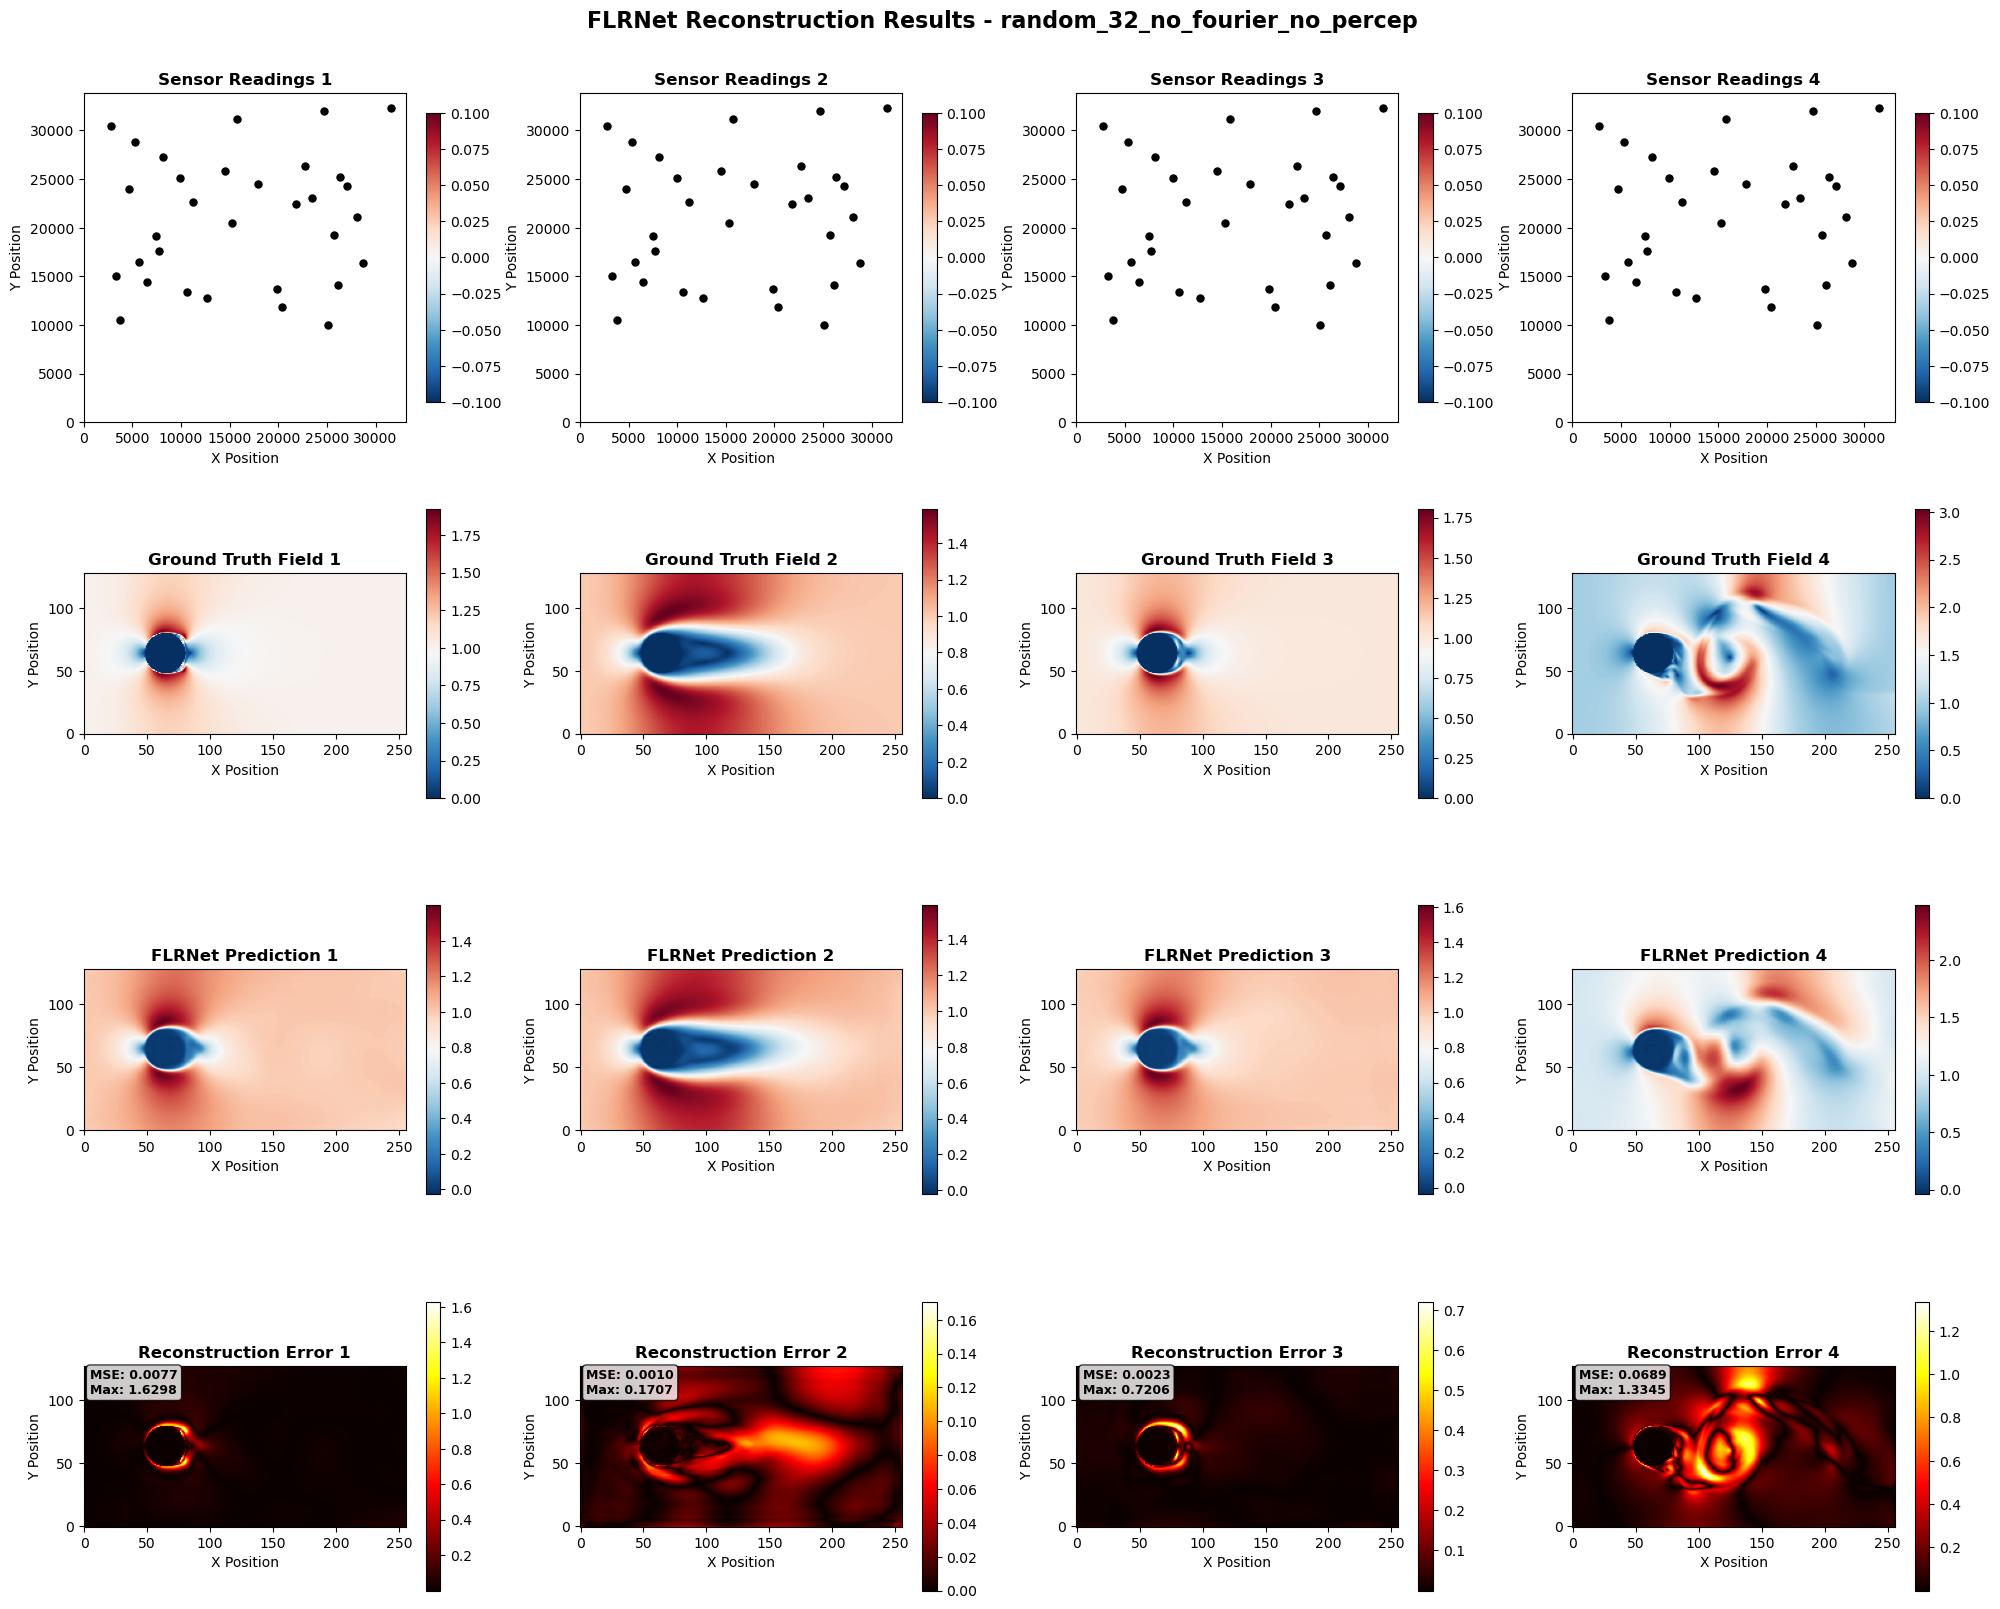


📈 Statistical Comparison:
   Original  - Mean: 1.0626, Std: 0.3510, Range: [0.0000, 3.0268]
   Predicted - Mean: 1.0483, Std: 0.3212, Range: [-0.0414, 2.4764]


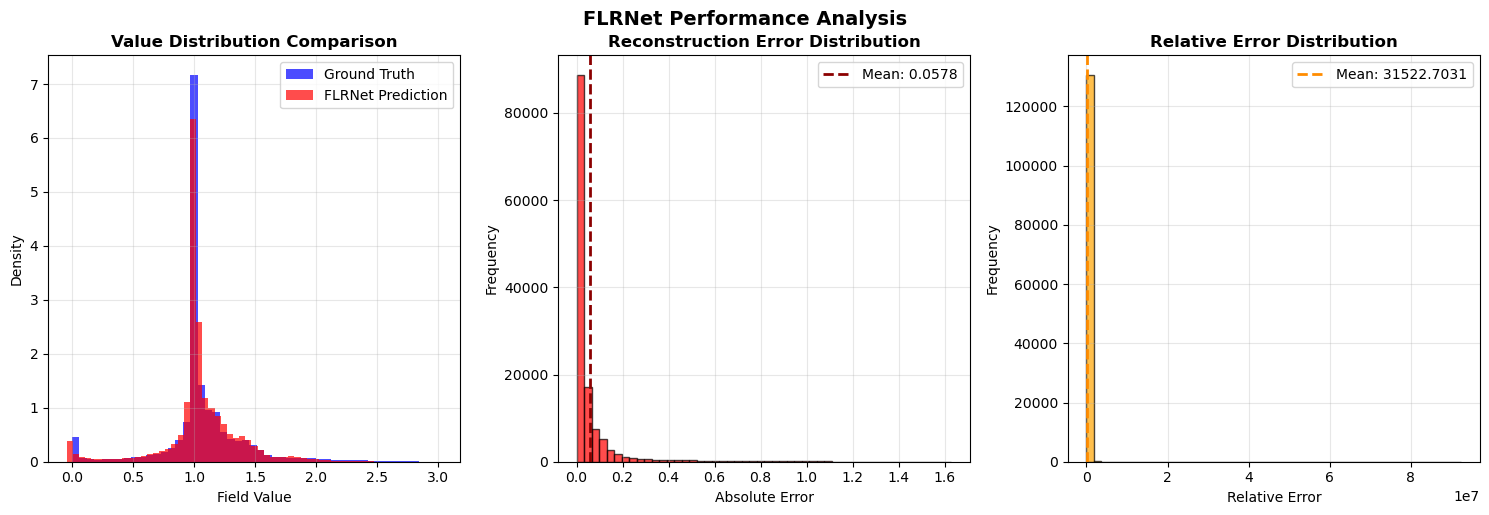


📡 Sensor Analysis:
   Number of sensors: 32
   Sensor value range: [0.3855, 2.7653]
   Sensor value std: 0.3831


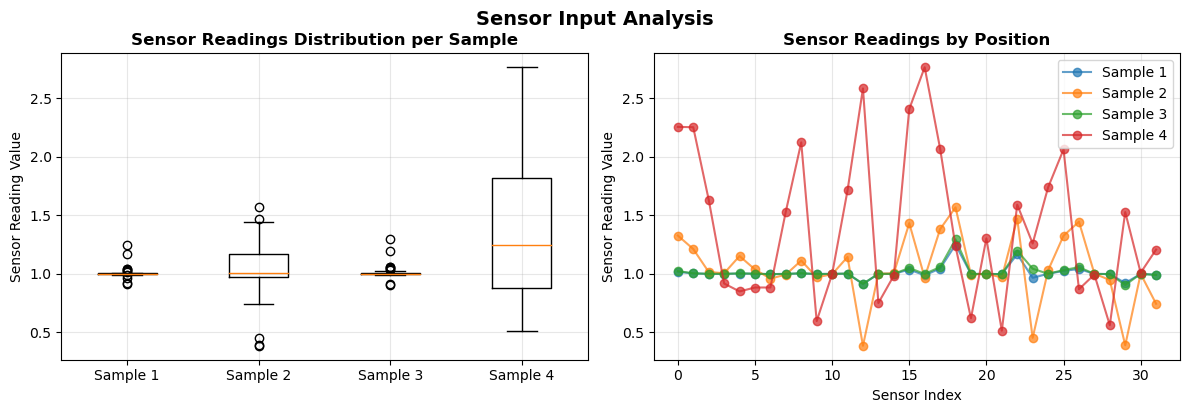


🔗 Reconstruction Quality Analysis:
   Sample MSEs: ['0.007675', '0.001021', '0.002331', '0.068856']
   Best reconstruction: Sample 2 (MSE: 0.001021)
   Worst reconstruction: Sample 4 (MSE: 0.068856)
   Field correlation coefficient: 0.9163

🎉 FLRNet visualization completed successfully!
   📊 Reconstruction Quality: ✅ Good
   🌊 Fourier Features: ➖ Not used
   📡 Sensor Count: 32 sensors
   🔗 Field Correlation: 0.9163


In [12]:
# Enhanced FLRNet Test Visualization
import matplotlib.pyplot as plt
import numpy as np

if trainer.flr_model is not None or 'test_flr_model' in locals():
    print("🎨 === FLRNet Test Visualization ===")
    
    # Use the test model if available, otherwise use trainer model
    flr_model_to_use = test_flr_model if 'test_flr_model' in locals() else trainer.flr_model
    print(f"Model type: {'Fourier-aware' if config['use_fourier'] else 'Standard'} FLRNet")
    
    # Get test data batch directly from the properly formatted dataset
    test_batch = next(iter(flrnet_test_dataset.take(1)))
    print("Using FLRNet test dataset")
    
    # Handle different input formats based on Fourier configuration
    if config['use_fourier']:
        # Fourier FLRNet expects (sensor_data, field_data, coordinates)
        sensor_data, field_data, coord_data = test_batch
        print(f"✅ Fourier FLRNet inputs detected:")
        print(f"   Sensor data shape: {sensor_data.shape}")
        print(f"   Field data shape: {field_data.shape}")
        print(f"   Coordinate data shape: {coord_data.shape}")
        
        # Generate FLRNet predictions
        print("\n🔮 Generating FLRNet reconstructions...")
        try:
            # Limit to manageable batch size for visualization
            max_samples = min(4, sensor_data.shape[0])
            
            limited_sensor = sensor_data[:max_samples]
            limited_field = field_data[:max_samples]
            limited_coord = coord_data[:max_samples]
            
            predictions = flr_model_to_use([limited_sensor, limited_field, limited_coord], training=False)
            print(f"✅ Reconstruction successful! Shape: {predictions.shape}")
            
            # Use limited_field as targets for comparison
            targets = limited_field
            
        except Exception as e:
            print(f"❌ FLRNet prediction failed: {e}")
            import traceback
            traceback.print_exc()

    else:
        # Standard FLRNet expects (sensor_data, field_data)
        sensor_data, field_data = test_batch
        print(f"✅ Standard FLRNet inputs:")
        print(f"   Sensor data shape: {sensor_data.shape}")
        print(f"   Field data shape: {field_data.shape}")
        
        # Generate FLRNet predictions
        print("\n🔮 Generating FLRNet reconstructions...")
        try:
            # Limit to manageable batch size for visualization
            max_samples = min(4, sensor_data.shape[0])
            
            limited_sensor = sensor_data[:max_samples]
            limited_field = field_data[:max_samples]
            
            predictions = flr_model_to_use([limited_sensor, limited_field], training=False)
            print(f"✅ Reconstruction successful! Shape: {predictions.shape}")
            
            # Use limited_field as targets for comparison
            targets = limited_field
            
        except Exception as e:
            print(f"❌ FLRNet prediction failed: {e}")
            import traceback
            traceback.print_exc()
    
    # Calculate reconstruction metrics
    mse = np.mean((targets.numpy() - predictions) ** 2)
    mae = np.mean(np.abs(targets.numpy() - predictions))
    max_error = np.max(np.abs(targets.numpy() - predictions))
    
    print(f"\n📊 FLRNet Reconstruction Metrics:")
    print(f"   MSE: {mse:.6f} ({'Excellent' if mse < 0.01 else 'Good' if mse < 0.05 else 'Needs improvement'})")
    print(f"   MAE: {mae:.6f}")
    print(f"   Max Error: {max_error:.6f}")
    
    # Create comprehensive visualization
    n_samples = max_samples
    fig, axes = plt.subplots(4, n_samples, figsize=(5*n_samples, 16))
    
    if n_samples == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_samples):
        # Sensor readings visualization (create a sensor field overlay)
        ax1 = axes[0, i]
        # Create a field to visualize sensor positions and values
        sensor_field = np.zeros((config['input_shape'][0], config['input_shape'][1]))
        
        # If we have sensor positions from dataset, use them
        if 'sensor_positions' in locals():
            for j, (x_pos, y_pos) in enumerate(sensor_positions):
                if j < len(limited_sensor[i]):
                    # Convert normalized positions to pixel coordinates
                    x_idx = int(x_pos * (config['input_shape'][1] - 1))
                    y_idx = int(y_pos * (config['input_shape'][0] - 1))
                    if 0 <= x_idx < config['input_shape'][1] and 0 <= y_idx < config['input_shape'][0]:
                        sensor_field[y_idx, x_idx] = limited_sensor[i, j]
        
        im1 = ax1.imshow(sensor_field, cmap='RdBu_r', origin='lower')
        ax1.set_title(f'Sensor Readings {i+1}', fontweight='bold')
        ax1.set_xlabel('X Position')
        ax1.set_ylabel('Y Position')
        plt.colorbar(im1, ax=ax1, shrink=0.8)
        
        # Add sensor positions as scatter points if available
        if 'sensor_positions' in locals():
            sensor_x = sensor_positions[:, 0] * (config['input_shape'][1] - 1)
            sensor_y = sensor_positions[:, 1] * (config['input_shape'][0] - 1)
            ax1.scatter(sensor_x, sensor_y, c='black', s=50, marker='o', edgecolors='white', linewidth=1)
        
        # Ground truth field
        im2 = axes[1, i].imshow(targets[i, :, :, 0], cmap='RdBu_r', origin='lower')
        axes[1, i].set_title(f'Ground Truth Field {i+1}', fontweight='bold')
        axes[1, i].set_xlabel('X Position')
        axes[1, i].set_ylabel('Y Position')
        plt.colorbar(im2, ax=axes[1, i], shrink=0.8)
        
        # FLRNet prediction
        im3 = axes[2, i].imshow(predictions[i, :, :, 0], cmap='RdBu_r', origin='lower')
        axes[2, i].set_title(f'FLRNet Prediction {i+1}', fontweight='bold')
        axes[2, i].set_xlabel('X Position')
        axes[2, i].set_ylabel('Y Position')
        plt.colorbar(im3, ax=axes[2, i], shrink=0.8)
        
        # Error map
        error = np.abs(targets[i, :, :, 0] - predictions[i, :, :, 0])
        im4 = axes[3, i].imshow(error, cmap='hot', origin='lower')
        axes[3, i].set_title(f'Reconstruction Error {i+1}', fontweight='bold')
        axes[3, i].set_xlabel('X Position')
        axes[3, i].set_ylabel('Y Position')
        plt.colorbar(im4, ax=axes[3, i], shrink=0.8)
        
        # Add error statistics as text
        sample_mse = np.mean(error**2)
        sample_max = np.max(error)
        axes[3, i].text(0.02, 0.98, f'MSE: {sample_mse:.4f}\nMax: {sample_max:.4f}', 
                       transform=axes[3, i].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                       fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.suptitle(f'FLRNet Reconstruction Results - {config_name}', y=1.02, fontsize=16, fontweight='bold')
    plt.show()
    
    # Statistical analysis
    print(f"\n📈 Statistical Comparison:")
    orig_stats = {
        'mean': np.mean(targets.numpy()),
        'std': np.std(targets.numpy()),
        'min': np.min(targets.numpy()),
        'max': np.max(targets.numpy())
    }
    
    pred_stats = {
        'mean': np.mean(predictions.numpy()),
        'std': np.std(predictions.numpy()),
        'min': np.min(predictions.numpy()),
        'max': np.max(predictions.numpy())
    }
    
    print(f"   Original  - Mean: {orig_stats['mean']:.4f}, Std: {orig_stats['std']:.4f}, Range: [{orig_stats['min']:.4f}, {orig_stats['max']:.4f}]")
    print(f"   Predicted - Mean: {pred_stats['mean']:.4f}, Std: {pred_stats['std']:.4f}, Range: [{pred_stats['min']:.4f}, {pred_stats['max']:.4f}]")
    
    # Distribution comparison
    plt.figure(figsize=(15, 5))
    
    # Value distributions
    plt.subplot(1, 3, 1)
    plt.hist(targets.numpy().flatten(), bins=50, alpha=0.7, label='Ground Truth', density=True, color='blue')
    plt.hist(predictions.numpy().flatten(), bins=50, alpha=0.7, label='FLRNet Prediction', density=True, color='red')
    plt.xlabel('Field Value')
    plt.ylabel('Density')
    plt.title('Value Distribution Comparison', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Error distribution
    plt.subplot(1, 3, 2)
    errors = np.abs(targets.numpy() - predictions).flatten()
    plt.hist(errors, bins=50, alpha=0.7, color='red', edgecolor='black')
    plt.xlabel('Absolute Error')
    plt.ylabel('Frequency')
    plt.title('Reconstruction Error Distribution', fontweight='bold')
    plt.axvline(np.mean(errors), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Relative error distribution
    plt.subplot(1, 3, 3)
    relative_errors = errors / (np.abs(targets.numpy().flatten()) + 1e-8)
    plt.hist(relative_errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
    plt.xlabel('Relative Error')
    plt.ylabel('Frequency')
    plt.title('Relative Error Distribution', fontweight='bold')
    plt.axvline(np.mean(relative_errors), color='darkorange', linestyle='--', linewidth=2, label=f'Mean: {np.mean(relative_errors):.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('FLRNet Performance Analysis', y=1.02, fontsize=14, fontweight='bold')
    plt.show()
    
    # Sensor analysis
    print(f"\n📡 Sensor Analysis:")
    print(f"   Number of sensors: {limited_sensor.shape[1]}")
    print(f"   Sensor value range: [{limited_sensor.numpy().min():.4f}, {limited_sensor.numpy().max():.4f}]")
    print(f"   Sensor value std: {limited_sensor.numpy().std():.4f}")
    
    # Show sensor readings distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.boxplot([limited_sensor[i, :].numpy() for i in range(n_samples)], 
                labels=[f'Sample {i+1}' for i in range(n_samples)])
    plt.ylabel('Sensor Reading Value')
    plt.title('Sensor Readings Distribution per Sample', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    for i in range(n_samples):
        plt.plot(limited_sensor[i, :].numpy(), 'o-', label=f'Sample {i+1}', alpha=0.7)
    plt.xlabel('Sensor Index')
    plt.ylabel('Sensor Reading Value')
    plt.title('Sensor Readings by Position', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Sensor Input Analysis', y=1.02, fontsize=14, fontweight='bold')
    plt.show()
    
    # Reconstruction quality analysis per sample
    print(f"\n🔗 Reconstruction Quality Analysis:")
    sample_mses = []
    sensor_means = []
    sensor_stds = []
    
    for i in range(n_samples):
        sample_error = np.abs(targets[i, :, :, 0] - predictions[i, :, :, 0])
        sample_mse = np.mean(sample_error**2)
        sample_mses.append(sample_mse)
        sensor_means.append(np.mean(limited_sensor[i, :]))
        sensor_stds.append(np.std(limited_sensor[i, :]))
    
    print(f"   Sample MSEs: {[f'{mse:.6f}' for mse in sample_mses]}")
    print(f"   Best reconstruction: Sample {np.argmin(sample_mses) + 1} (MSE: {min(sample_mses):.6f})")
    print(f"   Worst reconstruction: Sample {np.argmax(sample_mses) + 1} (MSE: {max(sample_mses):.6f})")
    
    # Correlation analysis
    correlation_field = np.corrcoef(targets.numpy().flatten(), predictions.numpy().flatten())[0, 1]
    print(f"   Field correlation coefficient: {correlation_field:.4f}")
    
    print(f"\n🎉 FLRNet visualization completed successfully!")
    print(f"   📊 Reconstruction Quality: {'🏆 Excellent' if mse < 0.01 else '✅ Good' if mse < 0.05 else '⚠️ Needs improvement'}")
    print(f"   🌊 Fourier Features: {'✅ Working correctly' if config['use_fourier'] else '➖ Not used'}")
    print(f"   📡 Sensor Count: {limited_sensor.shape[1]} sensors")
    print(f"   🔗 Field Correlation: {correlation_field:.4f}")
    
else:
    print("❌ No FLRNet model available for visualization")
    print("Please run the FLRNet model creation cell above first")

🎨 === VAE Test Visualization ===
Model type: Standard VAE
Using coordinate-aware VAE test dataset
✅ Standard VAE input: (8, 128, 256, 1)
   Target shape: (8, 128, 256, 1)

🔮 Generating VAE reconstructions...
✅ Reconstruction successful! Shape: (4, 128, 256, 1)

📊 VAE Reconstruction Metrics:
   MSE: 0.005751 (Excellent)
   MAE: 0.030427
   Max Error: 1.699652


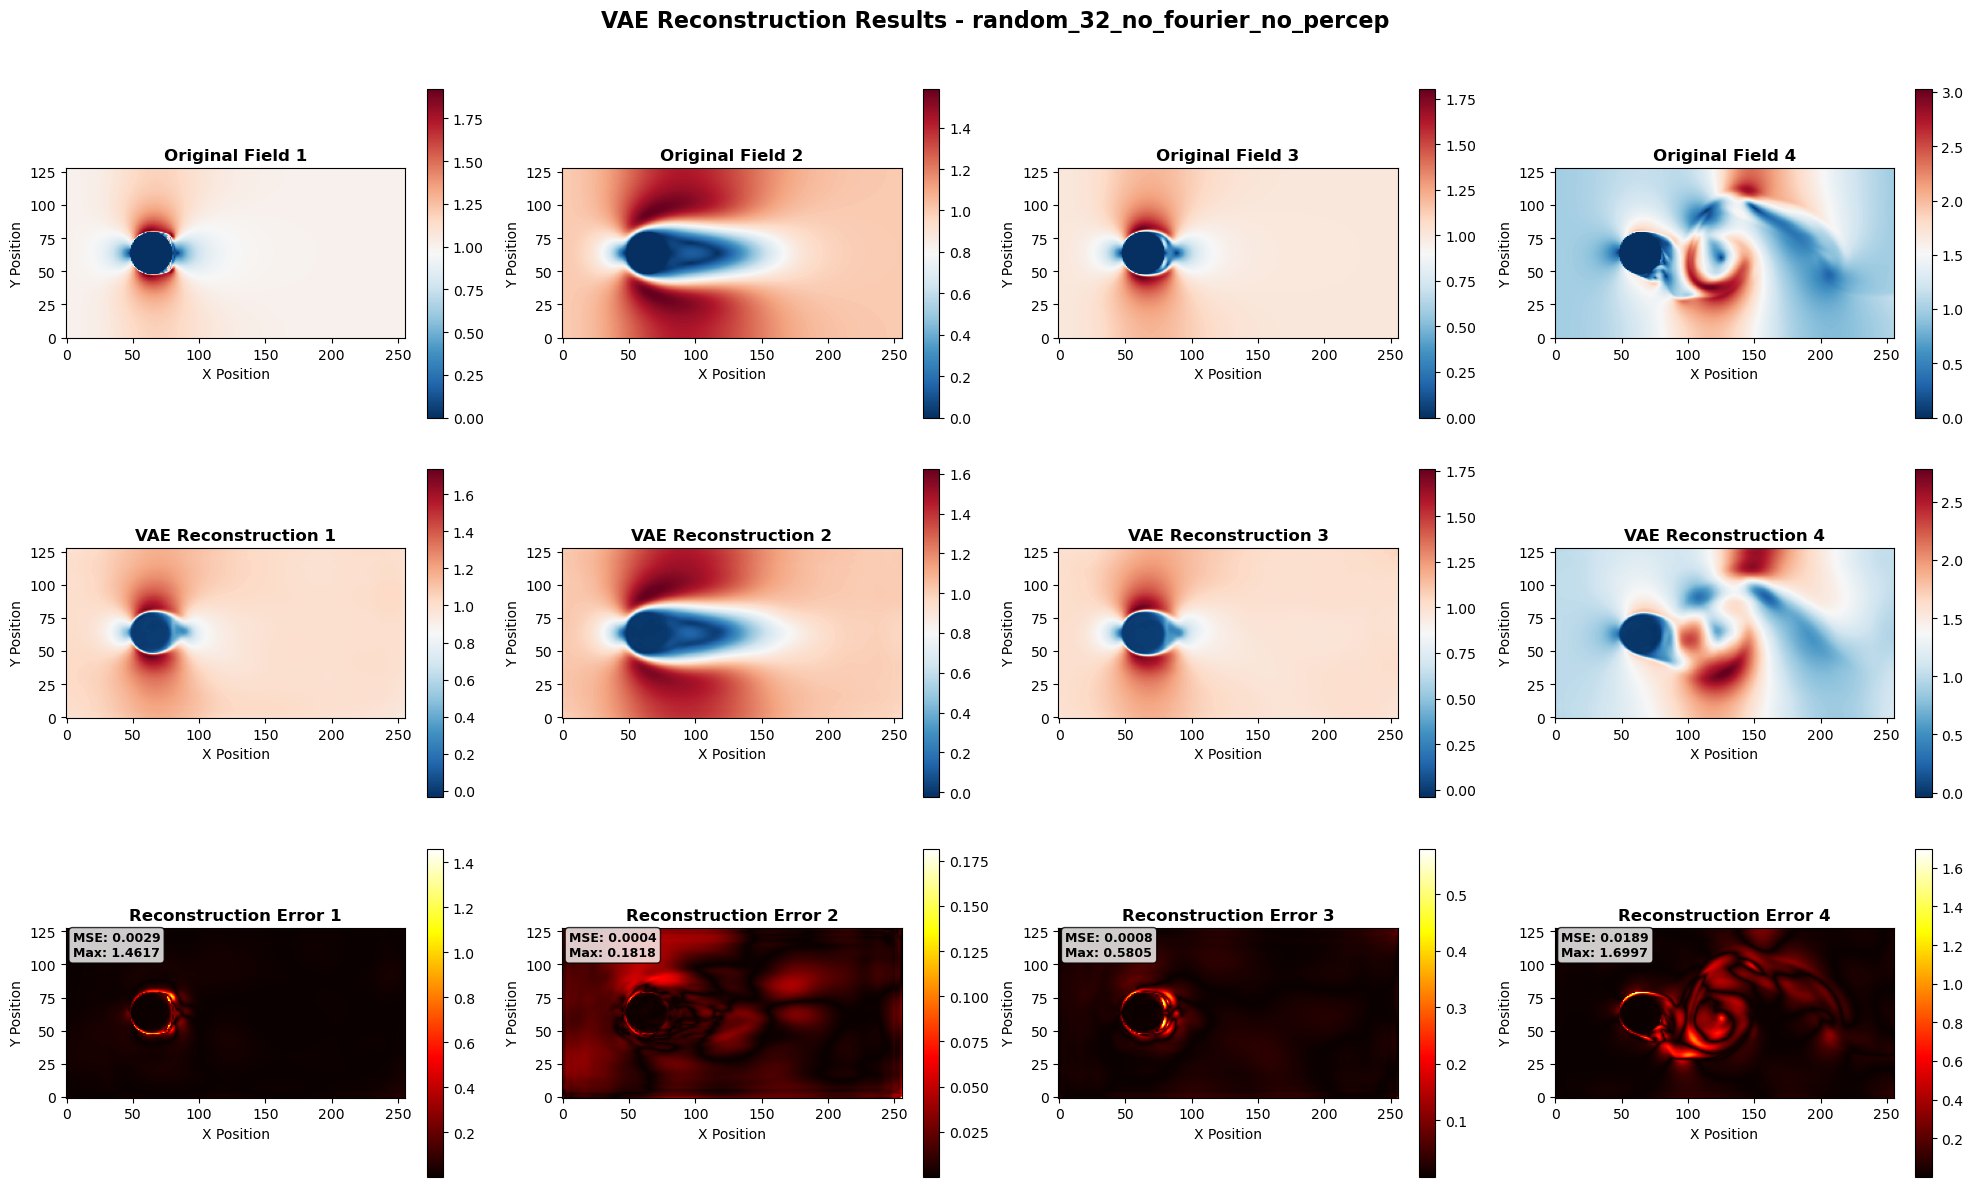


📈 Statistical Comparison:
   Original  - Mean: 1.0626, Std: 0.3510, Range: [0.0000, 3.0268]
   Reconstructed - Mean: 1.0691, Std: 0.3403, Range: [-0.0415, 2.7828]


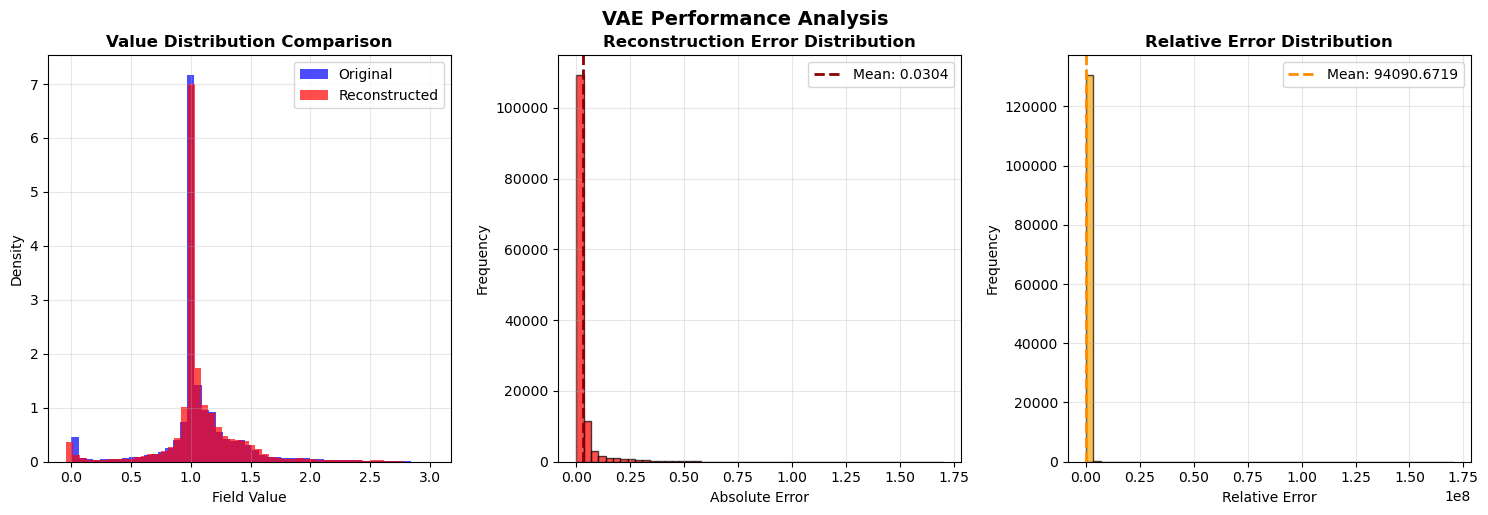


🎉 VAE visualization completed successfully!
   📊 Reconstruction Quality: 🏆 Excellent
   🌊 Fourier Features: ➖ Not used


In [13]:
# Enhanced VAE Test Visualization (replace the existing cell)

# Comprehensive VAE Test Visualization
import matplotlib.pyplot as plt
import numpy as np

if trainer.vae_model is not None:
    print("🎨 === VAE Test Visualization ===")
    print(f"Model type: {'Fourier-aware' if trainer.vae_model.use_fourier else 'Standard'} VAE")
    
    # Get test data batch directly from the properly formatted dataset
    test_batch = next(iter(vae_test_dataset.take(1)))
    print("Using coordinate-aware VAE test dataset")
    
    # Extract inputs and targets
    if isinstance(test_batch, tuple) and len(test_batch) == 2:
        test_inputs, test_targets = test_batch
        
        # Handle coordinate-aware inputs for Fourier VAE
        if isinstance(test_inputs, (list, tuple)) and len(test_inputs) == 2:
            test_fields, test_coords = test_inputs
            print(f"✅ Fourier VAE inputs detected:")
            print(f"   Field shape: {test_fields.shape}")
            print(f"   Coordinate shape: {test_coords.shape}")
            input_for_prediction = [test_fields, test_coords]
        else:
            test_fields = test_inputs
            print(f"✅ Standard VAE input: {test_fields.shape}")
            input_for_prediction = test_fields
        
        print(f"   Target shape: {test_targets.shape}")
        
        # Generate VAE reconstructions
        print("\n🔮 Generating VAE reconstructions...")
        try:
            # Limit to manageable batch size for visualization
            max_samples = min(4, test_fields.shape[0])
            
            if isinstance(input_for_prediction, list):
                limited_input = [test_fields[:max_samples], test_coords[:max_samples]]
            else:
                limited_input = test_fields[:max_samples]
            limited_targets = test_targets[:max_samples]
            
            reconstructions = trainer.vae_model.predict(limited_input, verbose=0)
            print(f"✅ Reconstruction successful! Shape: {reconstructions.shape}")
            
            # Calculate reconstruction metrics
            mse = np.mean((limited_targets.numpy() - reconstructions) ** 2)
            mae = np.mean(np.abs(limited_targets.numpy() - reconstructions))
            max_error = np.max(np.abs(limited_targets.numpy() - reconstructions))
            
            print(f"\n📊 VAE Reconstruction Metrics:")
            print(f"   MSE: {mse:.6f} ({'Excellent' if mse < 0.01 else 'Good' if mse < 0.05 else 'Needs improvement'})")
            print(f"   MAE: {mae:.6f}")
            print(f"   Max Error: {max_error:.6f}")
            
            # Create comprehensive visualization
            n_samples = max_samples
            fig, axes = plt.subplots(3, n_samples, figsize=(5*n_samples, 12))
            
            if n_samples == 1:
                axes = axes.reshape(-1, 1)
            
            for i in range(n_samples):
                # Original field
                im1 = axes[0, i].imshow(limited_targets[i, :, :, 0], cmap='RdBu_r', origin='lower')
                axes[0, i].set_title(f'Original Field {i+1}', fontweight='bold')
                axes[0, i].set_xlabel('X Position')
                axes[0, i].set_ylabel('Y Position')
                plt.colorbar(im1, ax=axes[0, i], shrink=0.8)
                
                # Reconstructed field
                im2 = axes[1, i].imshow(reconstructions[i, :, :, 0], cmap='RdBu_r', origin='lower')
                axes[1, i].set_title(f'VAE Reconstruction {i+1}', fontweight='bold')
                axes[1, i].set_xlabel('X Position')
                axes[1, i].set_ylabel('Y Position')
                plt.colorbar(im2, ax=axes[1, i], shrink=0.8)
                
                # Error map
                error = np.abs(limited_targets[i, :, :, 0] - reconstructions[i, :, :, 0])
                im3 = axes[2, i].imshow(error, cmap='hot', origin='lower')
                axes[2, i].set_title(f'Reconstruction Error {i+1}', fontweight='bold')
                axes[2, i].set_xlabel('X Position')
                axes[2, i].set_ylabel('Y Position')
                plt.colorbar(im3, ax=axes[2, i], shrink=0.8)
                
                # Add error statistics as text
                sample_mse = np.mean(error**2)
                sample_max = np.max(error)
                axes[2, i].text(0.02, 0.98, f'MSE: {sample_mse:.4f}\nMax: {sample_max:.4f}', 
                               transform=axes[2, i].transAxes, verticalalignment='top',
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                               fontsize=9, fontweight='bold')
            
            plt.tight_layout()
            plt.suptitle(f'VAE Reconstruction Results - {config_name}', y=1.02, fontsize=16, fontweight='bold')
            plt.show()
            
            # Statistical analysis
            print(f"\n📈 Statistical Comparison:")
            orig_stats = {
                'mean': np.mean(limited_targets.numpy()),
                'std': np.std(limited_targets.numpy()),
                'min': np.min(limited_targets.numpy()),
                'max': np.max(limited_targets.numpy())
            }
            
            recon_stats = {
                'mean': np.mean(reconstructions),
                'std': np.std(reconstructions),
                'min': np.min(reconstructions),
                'max': np.max(reconstructions)
            }
            
            print(f"   Original  - Mean: {orig_stats['mean']:.4f}, Std: {orig_stats['std']:.4f}, Range: [{orig_stats['min']:.4f}, {orig_stats['max']:.4f}]")
            print(f"   Reconstructed - Mean: {recon_stats['mean']:.4f}, Std: {recon_stats['std']:.4f}, Range: [{recon_stats['min']:.4f}, {recon_stats['max']:.4f}]")
            
            # Distribution comparison
            plt.figure(figsize=(15, 5))
            
            # Value distributions
            plt.subplot(1, 3, 1)
            plt.hist(limited_targets.numpy().flatten(), bins=50, alpha=0.7, label='Original', density=True, color='blue')
            plt.hist(reconstructions.flatten(), bins=50, alpha=0.7, label='Reconstructed', density=True, color='red')
            plt.xlabel('Field Value')
            plt.ylabel('Density')
            plt.title('Value Distribution Comparison', fontweight='bold')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # Error distribution
            plt.subplot(1, 3, 2)
            errors = np.abs(limited_targets.numpy() - reconstructions).flatten()
            plt.hist(errors, bins=50, alpha=0.7, color='red', edgecolor='black')
            plt.xlabel('Absolute Error')
            plt.ylabel('Frequency')
            plt.title('Reconstruction Error Distribution', fontweight='bold')
            plt.axvline(np.mean(errors), color='darkred', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.4f}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # Relative error distribution
            plt.subplot(1, 3, 3)
            relative_errors = errors / (np.abs(limited_targets.numpy().flatten()) + 1e-8)
            plt.hist(relative_errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
            plt.xlabel('Relative Error')
            plt.ylabel('Frequency')
            plt.title('Relative Error Distribution', fontweight='bold')
            plt.axvline(np.mean(relative_errors), color='darkorange', linestyle='--', linewidth=2, label=f'Mean: {np.mean(relative_errors):.4f}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.suptitle('VAE Performance Analysis', y=1.02, fontsize=14, fontweight='bold')
            plt.show()
            
            # Fourier feature analysis (if applicable)
            if trainer.vae_model.use_fourier and isinstance(test_inputs, (list, tuple)):
                print(f"\n🌊 Fourier Feature Analysis:")
                print(f"   Coordinate grid statistics:")
                print(f"   X coordinates - Range: [{np.min(test_coords[0, :, :, 0]):.3f}, {np.max(test_coords[0, :, :, 0]):.3f}]")
                print(f"   Y coordinates - Range: [{np.min(test_coords[0, :, :, 1]):.3f}, {np.max(test_coords[0, :, :, 1]):.3f}]")
                
                # Show coordinate grids for first sample
                fig, axes = plt.subplots(1, 2, figsize=(12, 5))
                
                im1 = axes[0].imshow(test_coords[0, :, :, 0], cmap='viridis', origin='lower')
                axes[0].set_title('X Coordinate Grid', fontweight='bold')
                axes[0].set_xlabel('X Position')
                axes[0].set_ylabel('Y Position')
                plt.colorbar(im1, ax=axes[0])
                
                im2 = axes[1].imshow(test_coords[0, :, :, 1], cmap='plasma', origin='lower')
                axes[1].set_title('Y Coordinate Grid', fontweight='bold')
                axes[1].set_xlabel('X Position')
                axes[1].set_ylabel('Y Position')
                plt.colorbar(im2, ax=axes[1])
                
                plt.tight_layout()
                plt.suptitle('Fourier Feature Coordinate Grids', y=1.02, fontsize=14, fontweight='bold')
                plt.show()
            
            print(f"\n🎉 VAE visualization completed successfully!")
            print(f"   📊 Reconstruction Quality: {'🏆 Excellent' if mse < 0.01 else '✅ Good' if mse < 0.05 else '⚠️ Needs improvement'}")
            print(f"   🌊 Fourier Features: {'✅ Working correctly' if trainer.vae_model.use_fourier else '➖ Not used'}")
            
        except Exception as e:
            print(f"❌ VAE prediction failed: {e}")
            import traceback
            traceback.print_exc()
    
    else:
        print(f"❌ Unexpected test batch structure: {type(test_batch)}")

else:
    print("❌ No VAE model available for visualization")

In [14]:
# Architecture Analysis and Summary
print("🏗️ === MODEL ARCHITECTURE ANALYSIS ===")
print("=" * 60)

# Check what models are available
models_available = {
    'VAE': trainer.vae_model is not None,
    'FLRNet': trainer.flr_model is not None,
    'Config': 'config' in locals()
}

print(f"📊 Available Components:")
for component, available in models_available.items():
    status = "✅ Loaded" if available else "❌ Not Available"
    print(f"   {component}: {status}")

print("\n" + "=" * 60)

# 1. Configuration Analysis
if 'config' in locals():
    print("🔧 CONFIGURATION ANALYSIS:")
    print(f"   📋 Config Name: {config_name}")
    print(f"   🌊 Fourier Features: {'✅ ENABLED' if config['use_fourier'] else '❌ DISABLED'}")
    print(f"   👁️  Perceptual Loss: {'✅ ENABLED' if config['use_perceptual_loss'] else '❌ DISABLED'}")
    print(f"   📐 Input Shape: {config['input_shape']}")
    print(f"   📡 Number of Sensors: {config['n_sensors']}")
    print(f"   🧠 Latent Dimensions: {config['latent_dims']}")
    print(f"   🔢 Base Features: {config['n_base_features']}")
    print(f"   📦 Batch Size: {config['batch_size']}")
    print(f"   📂 Checkpoint Dir: {config['checkpoint_dir']}")
    print(f"   📝 Model Name: {config['model_name']}")
else:
    print("⚠️  Configuration not available")

print("\n" + "=" * 60)

# 2. VAE Architecture Analysis
if trainer.vae_model is not None:
    print("🧠 VAE MODEL ARCHITECTURE:")
    vae = trainer.vae_model
    
    print(f"   📊 Model Type: {'Fourier-aware' if getattr(vae, 'use_fourier', False) else 'Standard'} VAE")
    print(f"   📐 Input Shape: {getattr(vae, 'input_shape_custom', 'Unknown')}")
    print(f"   🧠 Latent Dimensions: {getattr(vae, 'latent_dims', 'Unknown')}")
    print(f"   🔢 Base Features: {getattr(vae, 'n_base_features', 'Unknown')}")
    print(f"   👁️  Perceptual Loss: {'✅ ENABLED' if getattr(vae, 'use_perceptual_loss', False) else '❌ DISABLED'}")
    print(f"   ✂️  Gradient Clipping: {getattr(vae, 'gradient_clip_norm', 'Unknown')}")
    
    # Check for Fourier-specific components
    if hasattr(vae, 'use_fourier') and vae.use_fourier:
        print(f"   🌊 Fourier Components:")
        print(f"      - Coordinate Input: ✅ Required")
        print(f"      - Encoder: Fourier-aware")
        print(f"      - Decoder: Fourier-aware")
    
    # Check perceptual loss components
    if hasattr(vae, 'perceptual_model'):
        print(f"   👁️  Perceptual Model: ✅ Built")
    elif getattr(vae, 'use_perceptual_loss', False):
        print(f"   👁️  Perceptual Model: ⚠️  Expected but not found")
    
    # Model summary
    print(f"\n   📋 VAE Model Summary:")
    try:
        # Count parameters
        total_params = vae.count_params()
        trainable_params = sum([tf.keras.utils.count_params(w) for w in vae.trainable_weights])
        print(f"      - Total Parameters: {total_params:,}")
        print(f"      - Trainable Parameters: {trainable_params:,}")
        print(f"      - Non-trainable Parameters: {total_params - trainable_params:,}")
    except:
        print(f"      - Parameter count: Unable to calculate")
    
    # Check metrics
    if hasattr(vae, 'metrics'):
        metric_names = [m.name for m in vae.metrics]
        print(f"      - Available Metrics: {metric_names}")
else:
    print("❌ VAE MODEL: Not loaded")

print("\n" + "=" * 60)

# 3. FLRNet Architecture Analysis
if trainer.flr_model is not None:
    print("🔗 FLRNET MODEL ARCHITECTURE:")
    flr = trainer.flr_model
    
    print(f"   📊 Model Type: {'Fourier-aware' if getattr(flr, 'use_fourier', False) else 'Standard'} FLRNet")
    print(f"   📐 Input Shape: {getattr(flr, 'input_shape_custom', 'Unknown')}")
    print(f"   📡 Number of Sensors: {getattr(flr, 'n_sensors', 'Unknown')}")
    print(f"   🧠 Latent Dimensions: {getattr(flr, 'latent_dims', 'Unknown')}")
    print(f"   🔢 Base Features: {getattr(flr, 'n_base_features', 'Unknown')}")
    print(f"   👁️  Perceptual Loss: {'✅ ENABLED' if getattr(flr, 'use_perceptual_loss', False) else '❌ DISABLED'}")
    print(f"   🔒 Freeze Autoencoder: {'✅ FROZEN' if getattr(flr, 'freeze_autoencoder', False) else '❌ TRAINABLE'}")
    print(f"   ✂️  Gradient Clipping: {getattr(flr, 'gradient_clip_norm', 'Unknown')}")
    
    # Sensor Mapping Analysis - THIS IS KEY!
    if hasattr(flr, 'sensor_mapping'):
        sensor_mapping = flr.sensor_mapping
        print(f"\n   🎯 SENSOR MAPPING ARCHITECTURE:")
        
        # Check for attention vs dense architecture
        use_attention = getattr(sensor_mapping, 'use_attention', None)
        if use_attention is not None:
            print(f"      - Architecture Type: {'🧠 ATTENTION' if use_attention else '🔢 DENSE'}")
            
            if use_attention:
                # Attention architecture details
                attention_heads = getattr(sensor_mapping, 'attention_heads', 'Unknown')
                hidden_dim = getattr(sensor_mapping, 'hidden_dim', 'Unknown')
                print(f"      - Attention Heads: {attention_heads}")
                print(f"      - Hidden Dimension: {hidden_dim}")
                
                # Check for attention blocks
                if hasattr(sensor_mapping, 'attention_blocks'):
                    num_blocks = len(sensor_mapping.attention_blocks)
                    print(f"      - Attention Blocks: {num_blocks}")
                    print(f"      - Global Attention: {'✅' if hasattr(sensor_mapping, 'global_attention') else '❌'}")
                    print(f"      - Positional Encoding: {'✅' if hasattr(sensor_mapping, 'position_embedding') else '❌'}")
            else:
                # Dense architecture details
                print(f"      - Dense Layers: Traditional FC + BN + LeakyReLU")
                print(f"      - Noise Layer: {'✅' if hasattr(sensor_mapping, 'noise_layer') else '❌'}")
        else:
            print(f"      - Architecture Type: ⚠️  UNKNOWN (legacy model)")
            
            # Try to detect architecture by checking for attention components
            has_attention = (hasattr(sensor_mapping, 'attention_blocks') or 
                           hasattr(sensor_mapping, 'sensor_embedding') or
                           hasattr(sensor_mapping, 'global_attention'))
            has_dense = (hasattr(sensor_mapping, 'fc_1') or 
                        hasattr(sensor_mapping, 'leaky_1'))
            
            if has_attention:
                print(f"      - Detected: 🧠 ATTENTION components found")
            elif has_dense:
                print(f"      - Detected: 🔢 DENSE components found")
            else:
                print(f"      - Detected: ❓ Unable to determine")
    
    # Check AutoEncoder components
    if hasattr(flr, 'encoder') and hasattr(flr, 'decoder'):
        print(f"\n   🏗️  AutoEncoder Components:")
        print(f"      - Encoder: ✅ Present")
        print(f"      - Decoder: ✅ Present")
        
        # Check if frozen
        encoder_trainable = getattr(flr.encoder, 'trainable', 'Unknown')
        decoder_trainable = getattr(flr.decoder, 'trainable', 'Unknown')
        print(f"      - Encoder Trainable: {'❌ FROZEN' if encoder_trainable == False else '✅ TRAINABLE' if encoder_trainable == True else '❓ Unknown'}")
        print(f"      - Decoder Trainable: {'❌ FROZEN' if decoder_trainable == False else '✅ TRAINABLE' if decoder_trainable == True else '❓ Unknown'}")
    
    # Model summary
    print(f"\n   📋 FLRNet Model Summary:")
    try:
        # Count parameters
        total_params = flr.count_params()
        trainable_params = sum([tf.keras.utils.count_params(w) for w in flr.trainable_weights])
        print(f"      - Total Parameters: {total_params:,}")
        print(f"      - Trainable Parameters: {trainable_params:,}")
        print(f"      - Non-trainable Parameters: {total_params - trainable_params:,}")
        
        # Sensor mapping specific parameters
        if hasattr(flr, 'sensor_mapping'):
            sensor_params = flr.sensor_mapping.count_params()
            sensor_trainable = sum([tf.keras.utils.count_params(w) for w in flr.sensor_mapping.trainable_weights])
            print(f"      - Sensor Mapping Total: {sensor_params:,}")
            print(f"      - Sensor Mapping Trainable: {sensor_trainable:,}")
    except:
        print(f"      - Parameter count: Unable to calculate")
    
    # Check metrics
    if hasattr(flr, 'metrics'):
        metric_names = [m.name for m in flr.metrics]
        print(f"      - Available Metrics: {metric_names}")
else:
    print("❌ FLRNET MODEL: Not loaded")

print("\n" + "=" * 60)

# 4. Architecture Compatibility Analysis
print("🔍 ARCHITECTURE COMPATIBILITY ANALYSIS:")

if trainer.vae_model is not None and trainer.flr_model is not None:
    vae = trainer.vae_model
    flr = trainer.flr_model
    
    # Check Fourier compatibility
    vae_fourier = getattr(vae, 'use_fourier', False)
    flr_fourier = getattr(flr, 'use_fourier', False)
    fourier_match = vae_fourier == flr_fourier
    print(f"   🌊 Fourier Consistency: {'✅ MATCH' if fourier_match else '❌ MISMATCH'}")
    print(f"      - VAE Fourier: {'✅ ENABLED' if vae_fourier else '❌ DISABLED'}")
    print(f"      - FLRNet Fourier: {'✅ ENABLED' if flr_fourier else '❌ DISABLED'}")
    
    # Check perceptual loss compatibility
    vae_perceptual = getattr(vae, 'use_perceptual_loss', False)
    flr_perceptual = getattr(flr, 'use_perceptual_loss', False)
    perceptual_match = vae_perceptual == flr_perceptual
    print(f"   👁️  Perceptual Loss Consistency: {'✅ MATCH' if perceptual_match else '⚠️  DIFFERENT'}")
    print(f"      - VAE Perceptual: {'✅ ENABLED' if vae_perceptual else '❌ DISABLED'}")
    print(f"      - FLRNet Perceptual: {'✅ ENABLED' if flr_perceptual else '❌ DISABLED'}")
    
    # Check dimensional compatibility
    vae_latent = getattr(vae, 'latent_dims', None)
    flr_latent = getattr(flr, 'latent_dims', None)
    latent_match = vae_latent == flr_latent
    print(f"   🧠 Latent Dimension Consistency: {'✅ MATCH' if latent_match else '❌ MISMATCH'}")
    print(f"      - VAE Latent Dims: {vae_latent}")
    print(f"      - FLRNet Latent Dims: {flr_latent}")
    
    # Overall compatibility
    overall_compatible = fourier_match and latent_match
    print(f"\n   📊 Overall Compatibility: {'✅ COMPATIBLE' if overall_compatible else '⚠️  ISSUES DETECTED'}")
    
    if not overall_compatible:
        print(f"   🔧 Recommendations:")
        if not fourier_match:
            print(f"      - Fix Fourier feature mismatch between VAE and FLRNet")
        if not latent_match:
            print(f"      - Ensure latent dimensions match between models")
else:
    print("   ⚠️  Cannot analyze compatibility - models not loaded")

print("\n" + "=" * 60)

# 5. Training History Analysis (if available)
if hasattr(trainer, 'flr_model') and trainer.flr_model is not None:
    print("📈 TRAINING STATUS:")
    
    # Check if model has been trained (by looking for optimizer)
    if hasattr(trainer.flr_model, 'optimizer') and trainer.flr_model.optimizer is not None:
        print(f"   🎯 Model Status: ✅ TRAINED (optimizer configured)")
        print(f"   🔧 Optimizer: {type(trainer.flr_model.optimizer).__name__}")
        
        # Get learning rate if available
        try:
            lr = trainer.flr_model.optimizer.learning_rate
            if hasattr(lr, 'numpy'):
                lr_value = lr.numpy()
            else:
                lr_value = lr
            print(f"   📊 Current Learning Rate: {lr_value}")
        except:
            print(f"   📊 Current Learning Rate: Unable to retrieve")
    else:
        print(f"   🎯 Model Status: ⚠️  LOADED (not compiled/trained)")
    
    # Check checkpoint directory
    if 'checkpoint_directory' in locals():
        checkpoint_files = list(checkpoint_directory.glob("*flrnet*"))
        print(f"   📁 Checkpoint Files: {len(checkpoint_files)} found")
        
        # Show most recent checkpoint types
        checkpoint_types = set()
        for file in checkpoint_files:
            if 'best' in file.name:
                checkpoint_types.add('best')
            elif 'last' in file.name:
                checkpoint_types.add('last')
            elif 'final' in file.name:
                checkpoint_types.add('final')
            elif 'continued' in file.name:
                checkpoint_types.add('continued')
        
        print(f"   📋 Available Checkpoint Types: {list(checkpoint_types)}")

print("\n" + "=" * 60)
print("🎉 Architecture analysis completed!")
print("=" * 60)

🏗️ === MODEL ARCHITECTURE ANALYSIS ===
📊 Available Components:
   VAE: ✅ Loaded
   FLRNet: ✅ Loaded
   Config: ✅ Loaded

🔧 CONFIGURATION ANALYSIS:
   📋 Config Name: random_32_no_fourier_no_percep
   🌊 Fourier Features: ❌ DISABLED
   👁️  Perceptual Loss: ❌ DISABLED
   📐 Input Shape: (128, 256, 1)
   📡 Number of Sensors: 32
   🧠 Latent Dimensions: 8
   🔢 Base Features: 64
   📦 Batch Size: 8
   📂 Checkpoint Dir: ./checkpoints\fourierFalse_percepFalse_random_32
   📝 Model Name: fourierFalse_percepFalse_random_32

🧠 VAE MODEL ARCHITECTURE:
   📊 Model Type: Standard VAE
   📐 Input Shape: (128, 256, 1)
   🧠 Latent Dimensions: 8
   🔢 Base Features: 64
   👁️  Perceptual Loss: ❌ DISABLED
   ✂️  Gradient Clipping: 2.0

   📋 VAE Model Summary:
      - Total Parameters: 3,197,591
      - Trainable Parameters: 0
      - Non-trainable Parameters: 3,197,591
      - Available Metrics: ['total_loss', 'reconstruction_loss', 'kl_loss']

🔗 FLRNET MODEL ARCHITECTURE:
   📊 Model Type: Standard FLRNet
   📐 In

In [15]:
# Enhanced Parameter Count Analysis for Neural Network Architecture
import tensorflow as tf
import numpy as np

print("\n" + "="*80)
print("🔢 COMPREHENSIVE PARAMETER COUNT ANALYSIS")
print("="*80)

def get_model_memory_usage(model):
    """Calculate approximate memory usage of a model"""
    try:
        total_params = model.count_params()
        # Assume float32 (4 bytes per parameter)
        memory_mb = (total_params * 4) / (1024 * 1024)
        return memory_mb
    except:
        return None

def safe_count_params(weights):
    """Safely count parameters in weights, compatible across TF versions"""
    try:
        # Try the newer method first
        if hasattr(tf.keras.backend, 'count_params'):
            return tf.keras.backend.count_params(weights)
        # Fallback to manual counting
        elif hasattr(weights, 'shape'):
            return int(np.prod(weights.shape))
        else:
            return 0
    except:
        # Final fallback - manual calculation
        try:
            if hasattr(weights, 'numpy'):
                return int(np.prod(weights.numpy().shape))
            elif hasattr(weights, 'shape'):
                return int(np.prod(weights.shape))
            else:
                return 0
        except:
            return 0

def analyze_layer_details(layer, depth=0):
    """Recursively analyze layer structure and parameters"""
    indent = "  " * depth
    params = layer.count_params()
    
    # Safe trainable parameter counting
    trainable_params = 0
    if hasattr(layer, 'trainable_weights'):
        for weight in layer.trainable_weights:
            trainable_params += safe_count_params(weight)
    
    layer_info = {
        'name': layer.name if hasattr(layer, 'name') else 'unnamed',
        'type': type(layer).__name__,
        'total_params': params,
        'trainable_params': trainable_params,
        'non_trainable_params': params - trainable_params,
        'output_shape': getattr(layer, 'output_shape', 'Unknown'),
        'trainable': getattr(layer, 'trainable', True)
    }
    
    return layer_info

def print_detailed_model_analysis(model, model_name, max_layers=50):
    """Comprehensive model analysis with detailed breakdown"""
    try:
        print(f"\n🧠 {model_name.upper()} ANALYSIS")
        print("-" * 60)
        
        # Basic model info
        total_params = model.count_params()
        
        # Safe trainable parameter counting for the entire model
        trainable_params = 0
        if hasattr(model, 'trainable_weights'):
            for weight in model.trainable_weights:
                trainable_params += safe_count_params(weight)
        
        non_trainable_params = total_params - trainable_params
        memory_mb = get_model_memory_usage(model)
        
        print(f"📊 Overall Statistics:")
        print(f"   Total Parameters: {total_params:,}")
        print(f"   Trainable Parameters: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")
        print(f"   Non-trainable Parameters: {non_trainable_params:,} ({non_trainable_params/total_params*100:.1f}%)")
        if memory_mb:
            print(f"   Estimated Memory: {memory_mb:.2f} MB")
        
        # Model type detection
        model_type = type(model).__name__
        use_fourier = getattr(model, 'use_fourier', False)
        use_perceptual = getattr(model, 'use_perceptual_loss', False)
        
        print(f"   Model Type: {model_type}")
        print(f"   Fourier Features: {'✅ ENABLED' if use_fourier else '❌ DISABLED'}")
        print(f"   Perceptual Loss: {'✅ ENABLED' if use_perceptual else '❌ DISABLED'}")
        
        # Layer-by-layer analysis
        if hasattr(model, 'layers'):
            layers = model.layers
            print(f"\n📋 Layer Breakdown ({len(layers)} layers):")
            
            # Group layers by type for summary
            layer_type_counts = {}
            layer_type_params = {}
            
            # Show detailed breakdown (limit to prevent overwhelming output)
            shown_layers = min(len(layers), max_layers)
            if shown_layers < len(layers):
                print(f"   (Showing first {shown_layers} of {len(layers)} layers)")
            
            for i, layer in enumerate(layers[:shown_layers]):
                layer_info = analyze_layer_details(layer)
                
                # Count layer types
                layer_type = layer_info['type']
                layer_type_counts[layer_type] = layer_type_counts.get(layer_type, 0) + 1
                layer_type_params[layer_type] = layer_type_params.get(layer_type, 0) + layer_info['total_params']
                
                # Print layer details
                if layer_info['total_params'] > 0:
                    trainable_status = "🟢" if layer_info['trainable'] else "🔴"
                    print(f"   {i+1:2d}. {trainable_status} {layer_info['name']:20s} ({layer_info['type']:15s}) "
                          f"- {layer_info['total_params']:,} params")
                    
                    if layer_info['non_trainable_params'] > 0:
                        print(f"       └── Trainable: {layer_info['trainable_params']:,}, "
                              f"Non-trainable: {layer_info['non_trainable_params']:,}")
            
            # Layer type summary
            if layer_type_counts:
                print(f"\n📈 Layer Type Summary:")
                for layer_type, count in sorted(layer_type_counts.items()):
                    params = layer_type_params[layer_type]
                    percentage = (params / total_params * 100) if total_params > 0 else 0
                    print(f"   {layer_type:20s}: {count:2d} layers, {params:,} params ({percentage:.1f}%)")
        
        # Submodel analysis (for composite models)
        submodels = []
        for attr_name in ['encoder', 'decoder', 'sensor_mapping', 'perceptual_model']:
            if hasattr(model, attr_name):
                submodel = getattr(model, attr_name)
                if submodel is not None and hasattr(submodel, 'count_params'):
                    submodels.append((attr_name, submodel))
        
        if submodels:
            print(f"\n🏗️  Submodel Breakdown:")
            for submodel_name, submodel in submodels:
                try:
                    sub_params = submodel.count_params()
                    
                    # Safe trainable parameter counting for submodel
                    sub_trainable = 0
                    if hasattr(submodel, 'trainable_weights'):
                        for weight in submodel.trainable_weights:
                            sub_trainable += safe_count_params(weight)
                    
                    percentage = (sub_params / total_params * 100) if total_params > 0 else 0
                    trainable_status = "🟢" if getattr(submodel, 'trainable', True) else "🔴"
                    
                    print(f"   {trainable_status} {submodel_name.title():15s}: {sub_params:,} params ({percentage:.1f}%)")
                    if sub_params != sub_trainable:
                        print(f"       └── Trainable: {sub_trainable:,}, Non-trainable: {sub_params - sub_trainable:,}")
                except Exception as e:
                    print(f"   ❌ {submodel_name.title():15s}: Error counting parameters - {str(e)[:50]}")
        
        return {
            'total_params': total_params,
            'trainable_params': trainable_params,
            'non_trainable_params': non_trainable_params,
            'memory_mb': memory_mb,
            'layer_types': layer_type_counts,
            'submodels': {name: sub.count_params() if hasattr(sub, 'count_params') else 0 for name, sub in submodels}
        }
        
    except Exception as e:
        print(f"❌ Error analyzing {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Main analysis section
models_to_analyze = []

# Check for available models and add them to analysis list
if 'trainer' in locals() and hasattr(trainer, 'flr_model') and trainer.flr_model is not None:
    models_to_analyze.append(('FLRNet', trainer.flr_model))
elif 'flr_model' in locals() and flr_model is not None:
    models_to_analyze.append(('FLRNet', flr_model))

if 'trainer' in locals() and hasattr(trainer, 'vae_model') and trainer.vae_model is not None:
    models_to_analyze.append(('VAE', trainer.vae_model))
elif 'vae_model' in locals() and vae_model is not None:
    models_to_analyze.append(('VAE', vae_model))

if not models_to_analyze:
    print("❌ No models found for analysis!")
    print("🔧 Available variables:", [var for var in locals().keys() if 'model' in var.lower()])
    print("🔧 Make sure to load models first using the checkpoint loading cells")
else:
    print(f"📊 Found {len(models_to_analyze)} model(s) for analysis")

# Analyze each model
model_stats = {}
total_system_params = 0

for model_name, model in models_to_analyze:
    stats = print_detailed_model_analysis(model, model_name)
    if stats:
        model_stats[model_name] = stats
        total_system_params += stats['total_params']

# System-wide summary
if len(models_to_analyze) > 1:
    print(f"\n🌐 SYSTEM-WIDE SUMMARY")
    print("-" * 60)
    print(f"Total System Parameters: {total_system_params:,}")
    
    total_trainable = sum(stats['trainable_params'] for stats in model_stats.values())
    total_non_trainable = sum(stats['non_trainable_params'] for stats in model_stats.values())
    total_memory = sum(stats['memory_mb'] for stats in model_stats.values() if stats['memory_mb'])
    
    print(f"Total Trainable: {total_trainable:,} ({total_trainable/total_system_params*100:.1f}%)")
    print(f"Total Non-trainable: {total_non_trainable:,} ({total_non_trainable/total_system_params*100:.1f}%)")
    if total_memory > 0:
        print(f"Total Estimated Memory: {total_memory:.2f} MB")
    
    # Model comparison
    print(f"\n📊 Model Comparison:")
    for model_name, stats in model_stats.items():
        percentage = (stats['total_params'] / total_system_params * 100)
        print(f"   {model_name:10s}: {stats['total_params']:,} params ({percentage:.1f}% of total)")

# Parameter efficiency analysis
if model_stats:
    print(f"\n⚡ PARAMETER EFFICIENCY ANALYSIS")
    print("-" * 60)
    
    for model_name, stats in model_stats.items():
        total_params = stats['total_params']
        
        # Categorize model size
        if total_params < 1_000_000:
            size_category = "🟢 Lightweight"
        elif total_params < 10_000_000:
            size_category = "🟡 Medium"
        elif total_params < 50_000_000:
            size_category = "🟠 Large"
        else:
            size_category = "🔴 Very Large"
        
        print(f"{model_name}:")
        print(f"   Size Category: {size_category}")
        print(f"   Parameters per MB: {total_params / (stats['memory_mb'] or 1):,.0f}")
        
        # Training efficiency
        trainable_ratio = stats['trainable_params'] / total_params if total_params > 0 else 0
        if trainable_ratio > 0.9:
            training_efficiency = "🟢 Fully Trainable"
        elif trainable_ratio > 0.5:
            training_efficiency = "🟡 Partially Frozen"
        else:
            training_efficiency = "🔴 Mostly Frozen"
        
        print(f"   Training Efficiency: {training_efficiency} ({trainable_ratio*100:.1f}% trainable)")

# Additional diagnostic information
print(f"\n🔧 DIAGNOSTIC INFORMATION")
print("-" * 60)
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras backend: {tf.keras.backend.backend()}")

# Test parameter counting methods
print(f"\nParameter counting method compatibility:")
if hasattr(tf.keras.backend, 'count_params'):
    print("   ✅ tf.keras.backend.count_params available")
else:
    print("   ❌ tf.keras.backend.count_params not available")

if hasattr(tf.keras.utils, 'count_params'):
    print("   ✅ tf.keras.utils.count_params available")
else:
    print("   ❌ tf.keras.utils.count_params not available")

print(f"\n" + "="*80)
print("🎉 Parameter analysis completed!")
print("="*80)


🔢 COMPREHENSIVE PARAMETER COUNT ANALYSIS
📊 Found 2 model(s) for analysis

🧠 FLRNET ANALYSIS
------------------------------------------------------------
📊 Overall Statistics:
   Total Parameters: 18,446,441
   Trainable Parameters: 534,160 (2.9%)
   Non-trainable Parameters: 17,912,281 (97.1%)
   Estimated Memory: 70.37 MB
   Model Type: FLRNet
   Fourier Features: ❌ DISABLED
   Perceptual Loss: ✅ ENABLED

📋 Layer Breakdown (4 layers):
    1. 🔴 vae_encoder          (FLREncoder     ) - 1,312,976 params
       └── Trainable: 0, Non-trainable: 1,312,976
    2. 🔴 vae_decoder          (FLRDecoder     ) - 1,884,609 params
       └── Trainable: 0, Non-trainable: 1,884,609
    3. 🟢 sensor_mapping       (SensorMapping  ) - 534,160 params
    4. 🟢 model                (Functional     ) - 14,714,688 params
       └── Trainable: 0, Non-trainable: 14,714,688

📈 Layer Type Summary:
   FLRDecoder          :  1 layers, 1,884,609 params (10.2%)
   FLREncoder          :  1 layers, 1,312,976 params (7.1